# Granule Cell

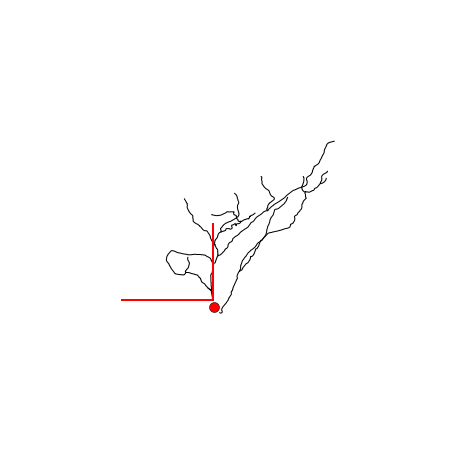

In [1]:
from neuron import h
from PyNeuronToolbox import neuromorpho,morphology
import pylab as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm
import numpy as np
from palettable.cubehelix import Cubehelix

u_cmap = cm.cool
us_cmap = Cubehelix.make(start=1, min_light=0.0, max_light=0.9, max_sat=6.0, rotation=0.13).mpl_colormap

fig = plt.figure(figsize=(8,8))
xsc = np.array([0,100])
ysc = np.array([0,0])
view = (-90,90)

cellname = 'granule'
neuromorpho.download('041015-vehicle1', filename=cellname+'_morph.swc')
cell = morphology.load(cellname+'_morph.swc',use_axon=False)

ax = fig.gca(projection='3d')
morphology.shapeplot(h, ax, sections=cell.dend, color='k')
morphology.mark_locations(h,cell.soma[0], 0.5, color='r', ms=10)
ax.plot(xsc,ysc,'-r',lw=2)
ax.plot(ysc,xsc,'-r',lw=2)
ax.view_init(*view)
ax.set_axis_off()
plt.savefig(cellname+'_morph.eps')
plt.show()

# Without Reattachment

In [2]:
import sushi

A,u,t,err,final_err = sushi.run_uniform_sim(h, 8e-5, 10.0)
sushi.snapshots(h,u,t,'plots/no_reattach',cellname,view,u_cmap,us_cmap)
N = int(A.shape[1] / 2)
tss = sushi.calc_time_to_ss(A, u[0,:])
np.savetxt('./data/no_reattach/'+cellname+'_pt.txt',np.array([tss, err[-1]]))

print 'mean percent error  = %2.2f'%(err[-1])
print 'time to reach within 10 perc of ss: %f min'%(tss/60)

mean percent error  = 11.76
time to reach within 10 perc of ss: 479.703886 min



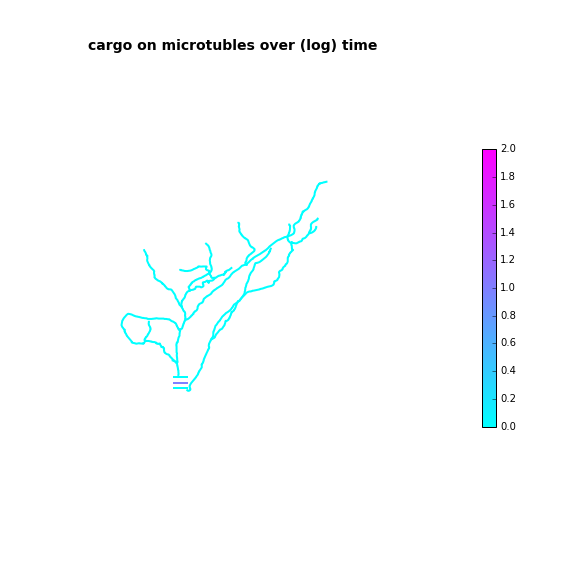
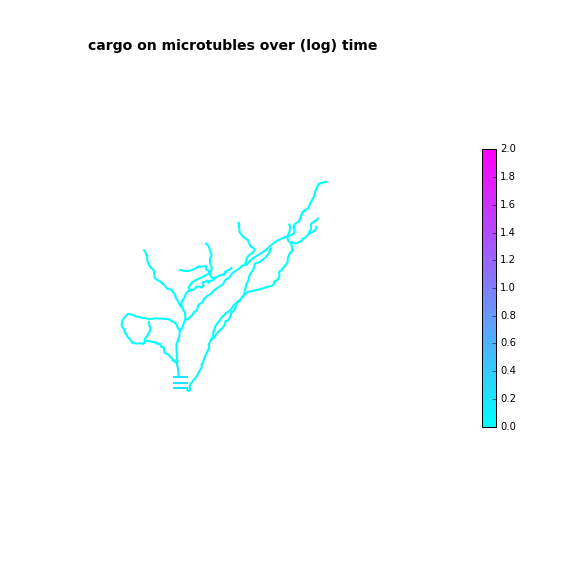
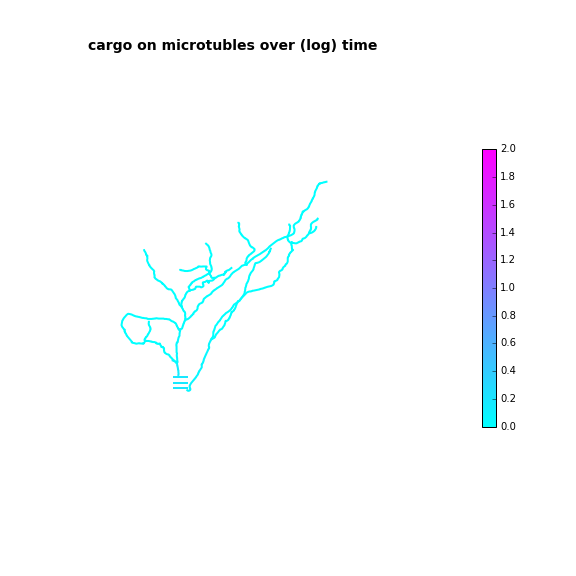
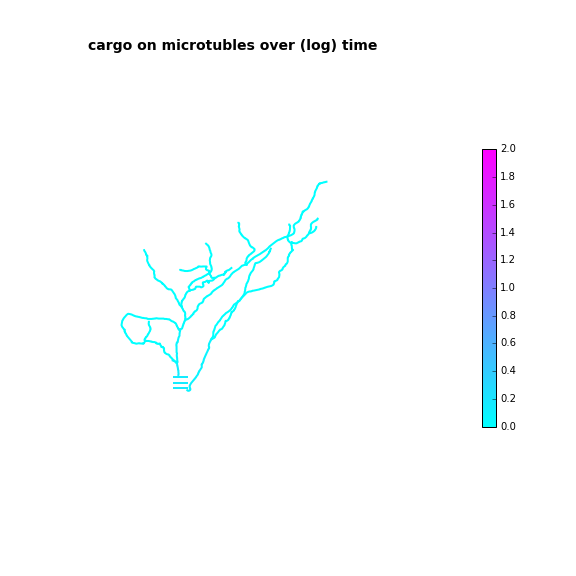
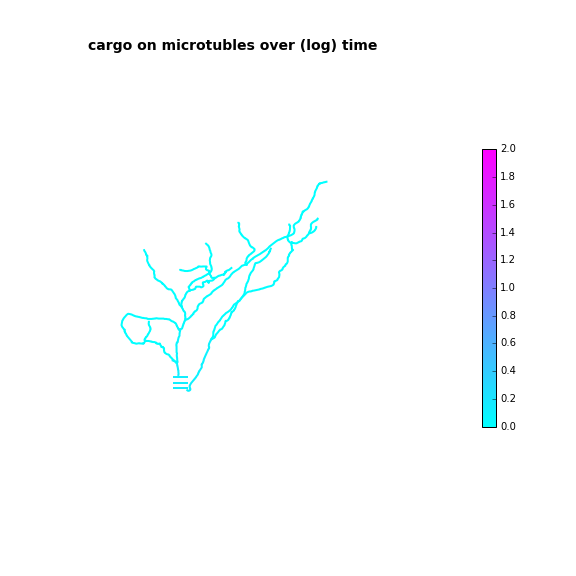
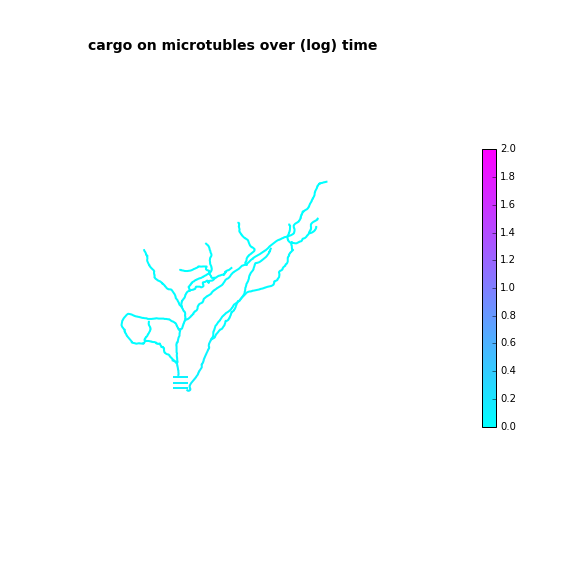
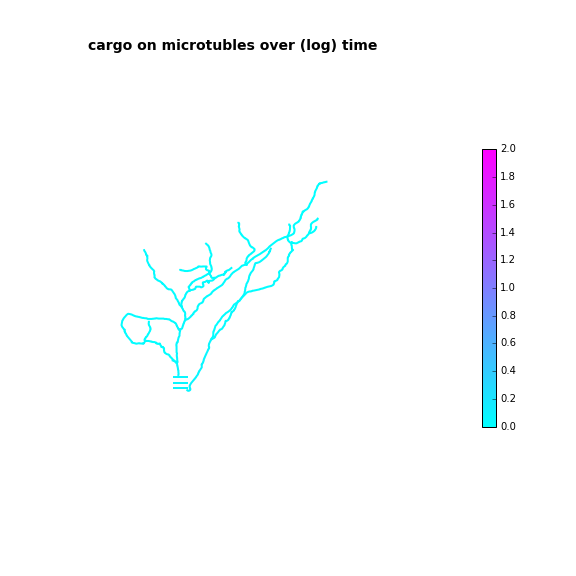
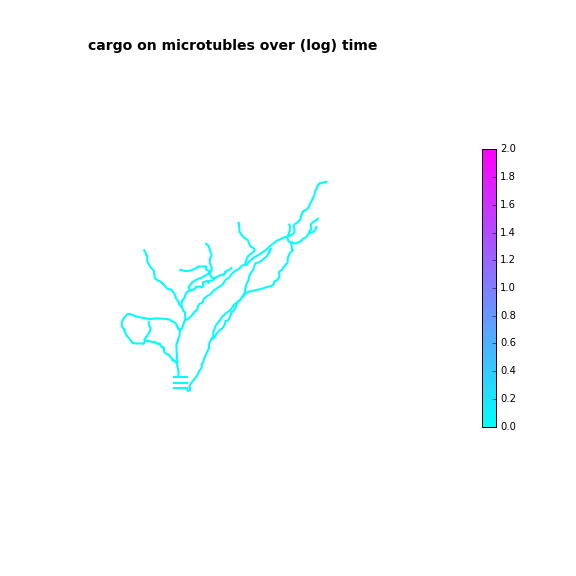
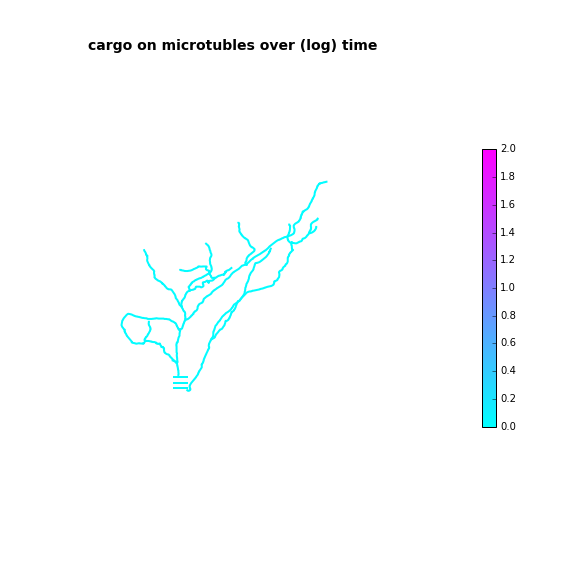
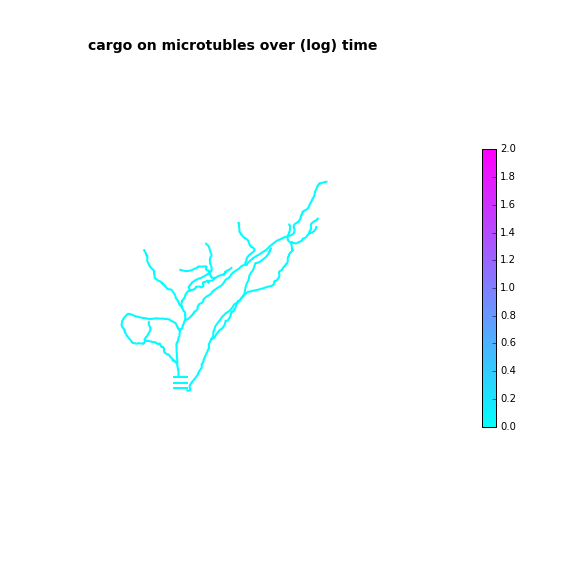
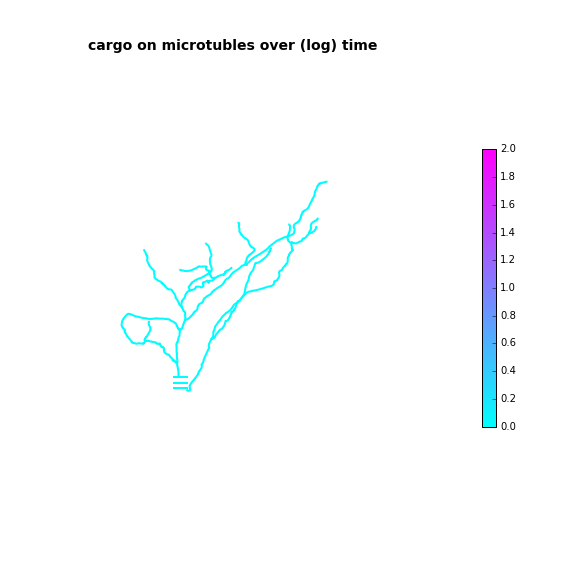
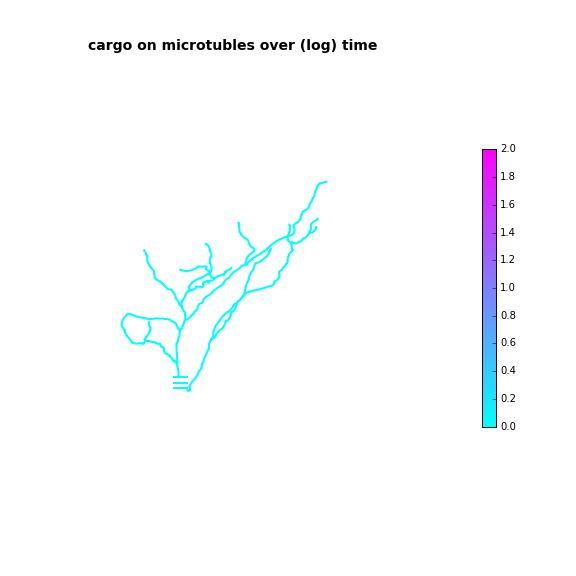
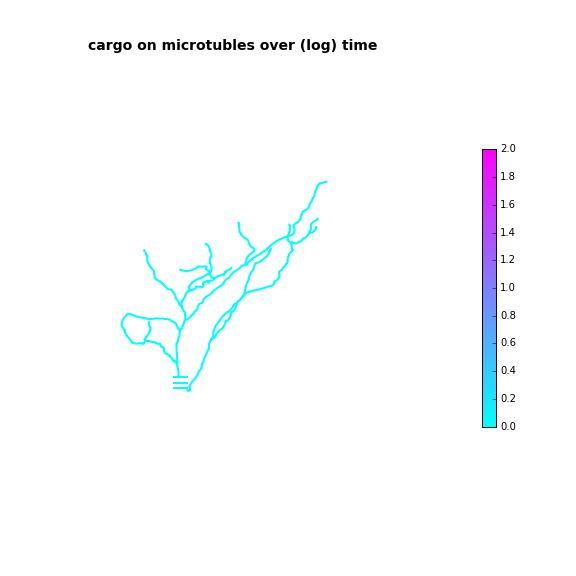
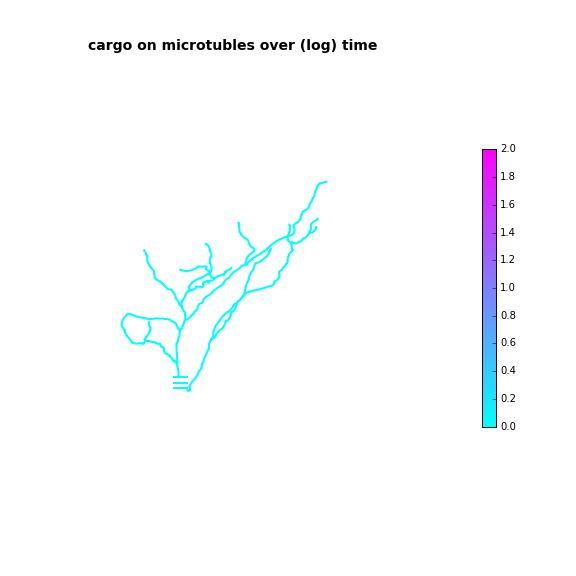
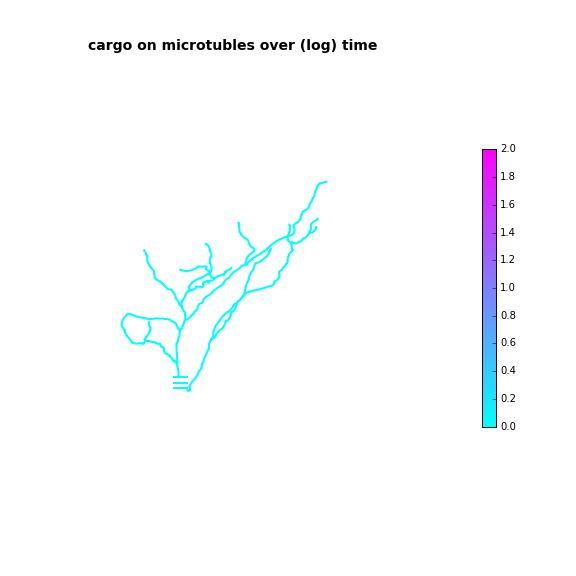
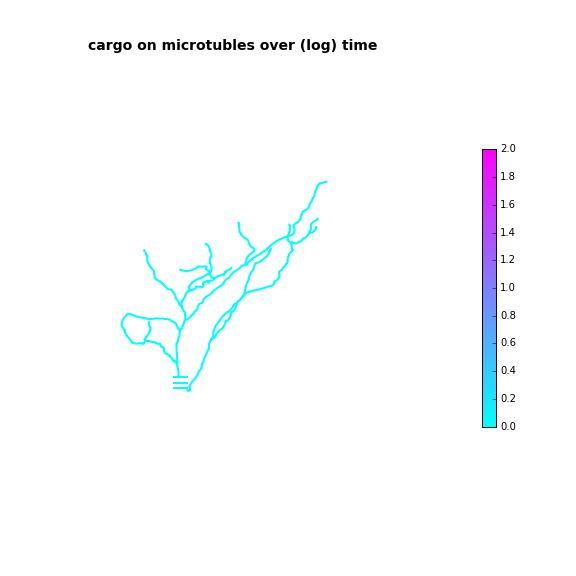
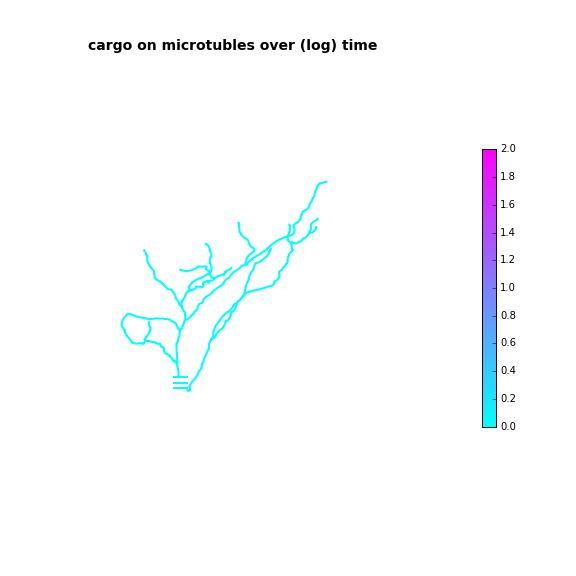
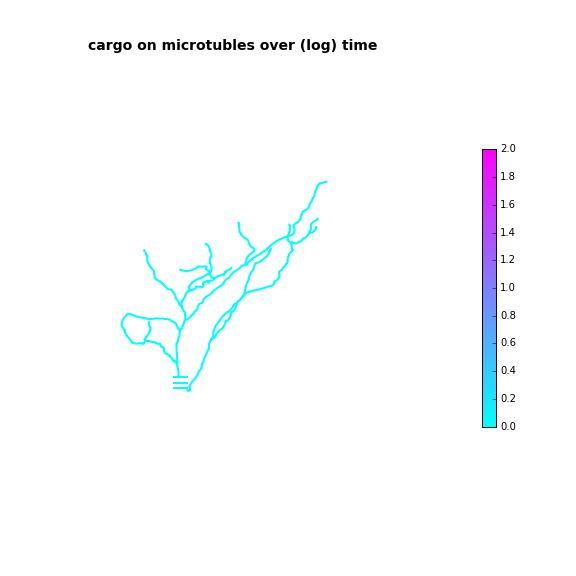
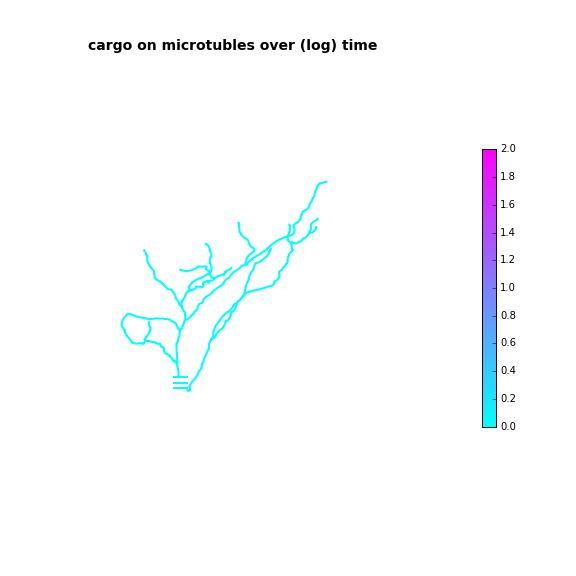
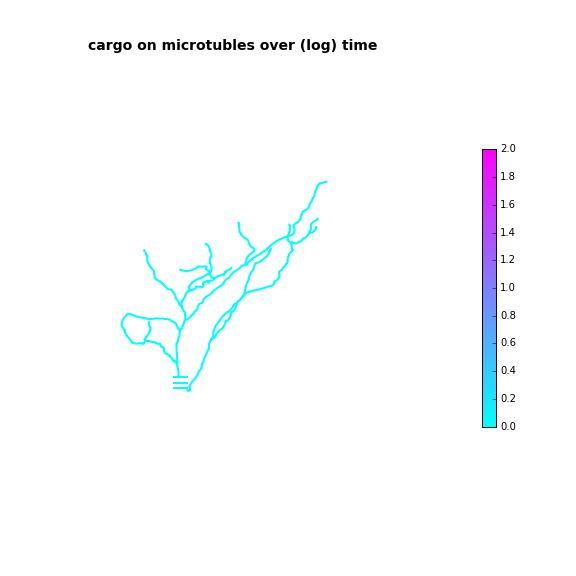
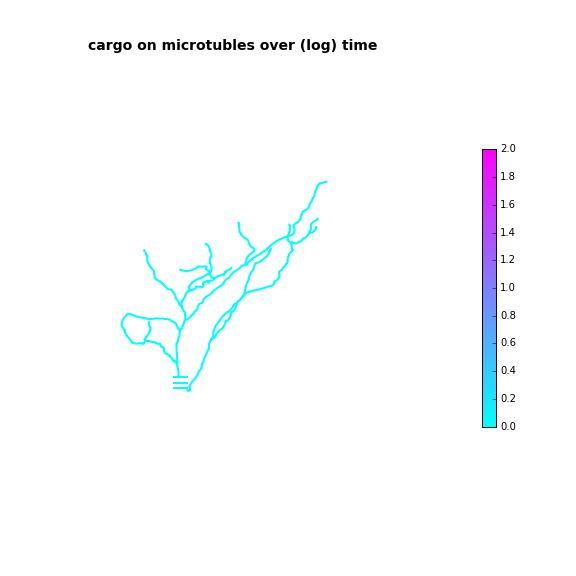
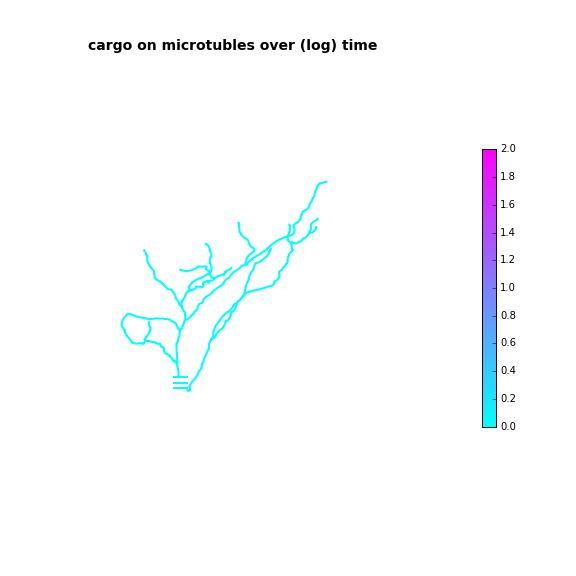
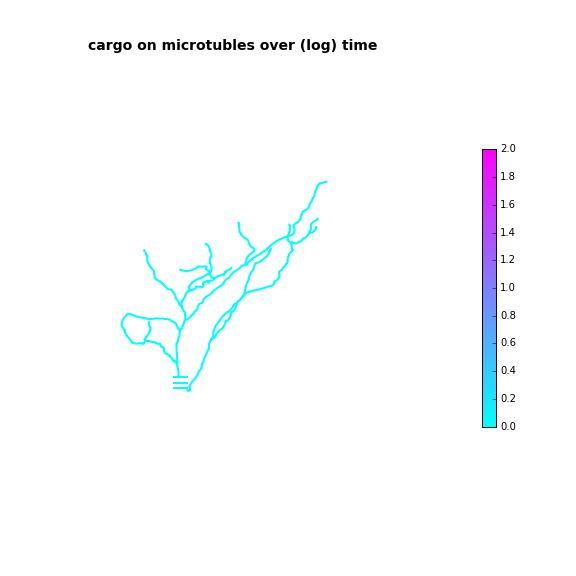
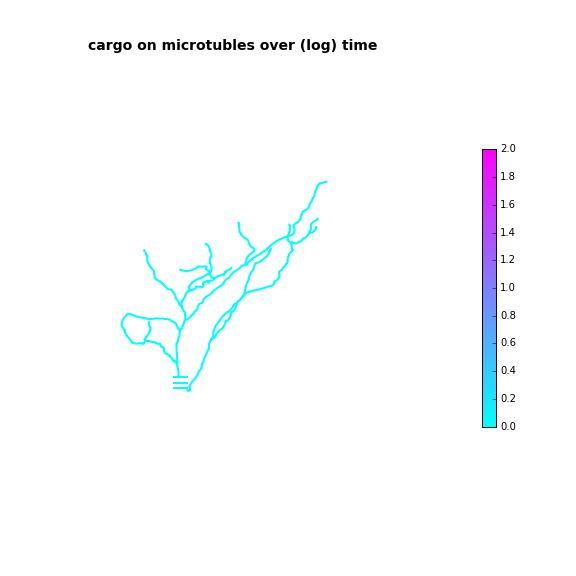

In [3]:
# Animation to show distribution on the microtubules
from PyNeuronToolbox.morphology import shapeplot_animate
from JSAnimation import IPython_display
from matplotlib import animation

clim = [0,2]
nframes = u.shape[0]

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
lines = morphology.shapeplot(h,ax,order='pre',lw=2)
ax.view_init(*view)
ax.set_axis_off()
plt.title('cargo on microtubles over (log) time',fontweight='bold',fontsize=14)

# Hack to get a colorbar
# http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap=u_cmap, norm=plt.Normalize(clim[0],clim[1])) 
sm._A = []
plt.colorbar(sm, shrink=0.5)
plt.tight_layout()

#plt.show()
anim_func = morphology.shapeplot_animate(u[:,:N],lines,nframes,clim=clim,cmap=u_cmap)
anim = animation.FuncAnimation(fig, anim_func, frames=nframes, interval=400)
anim.save('./anim/with_reattach/'+cellname+'_u.mp4'); anim


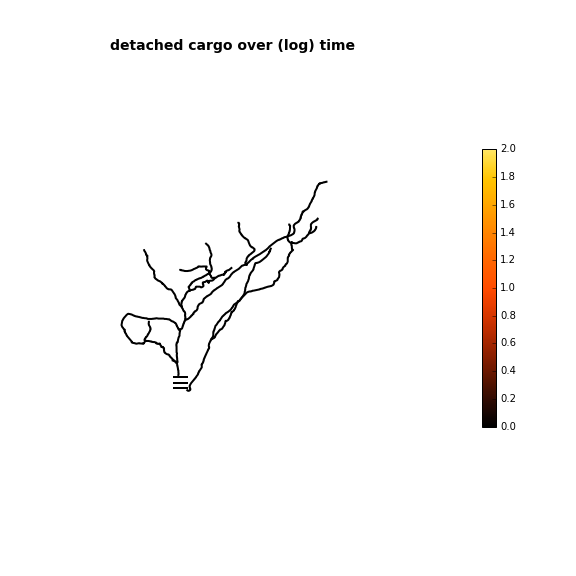
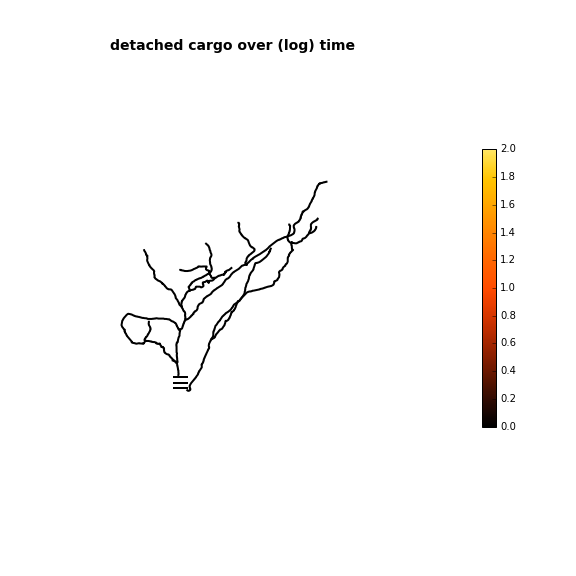
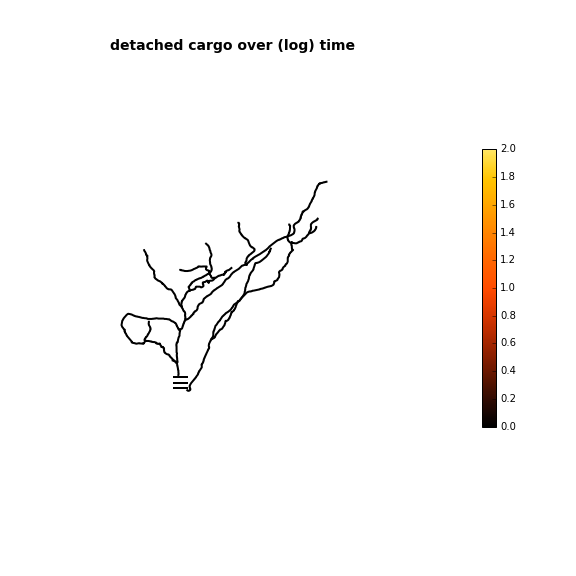
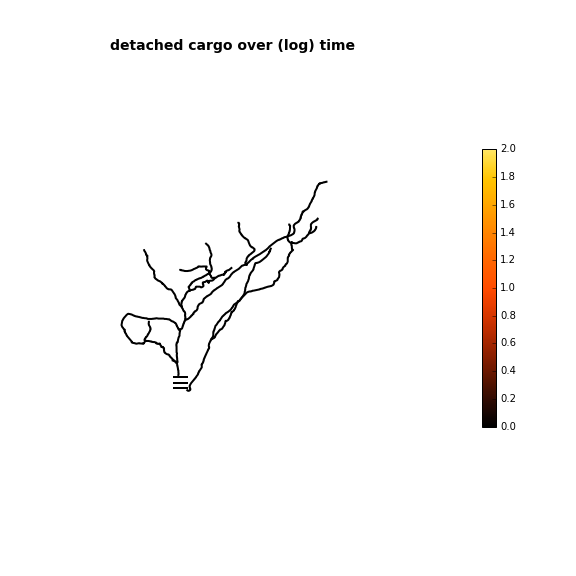
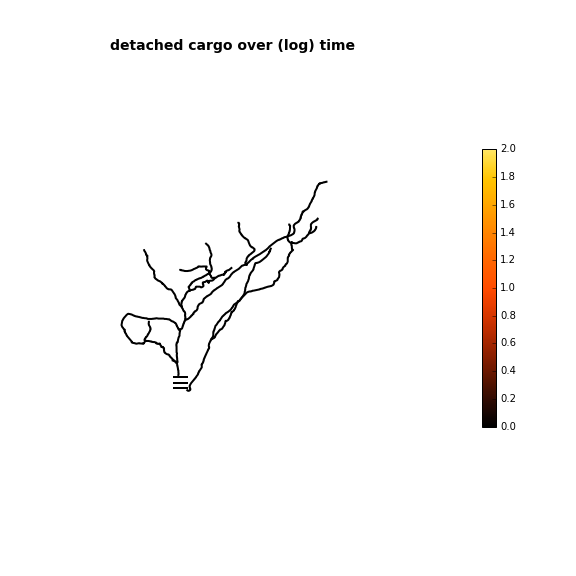
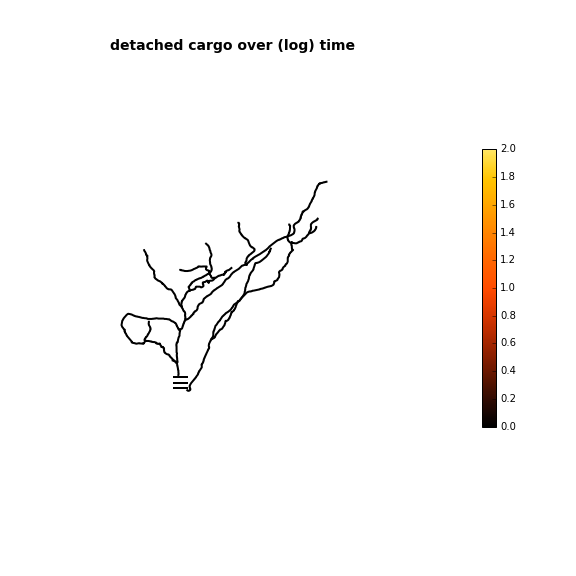
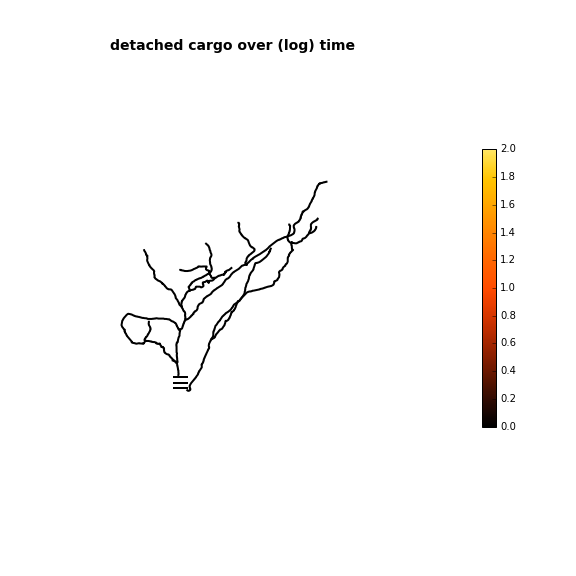
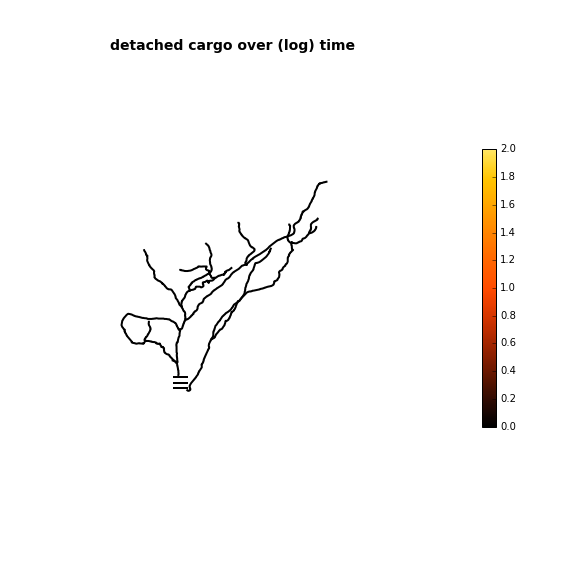
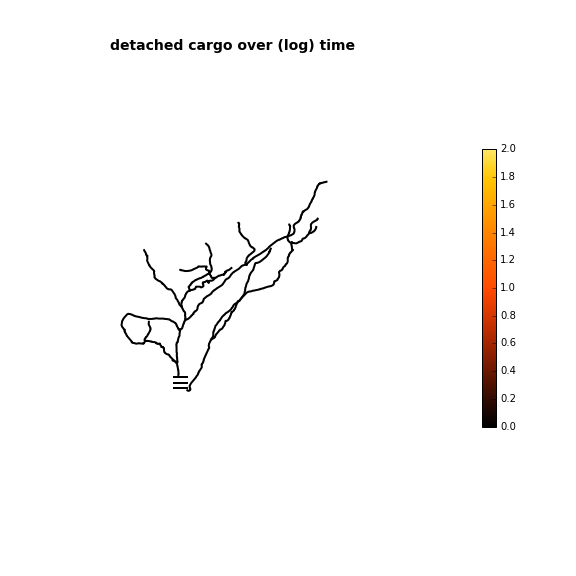
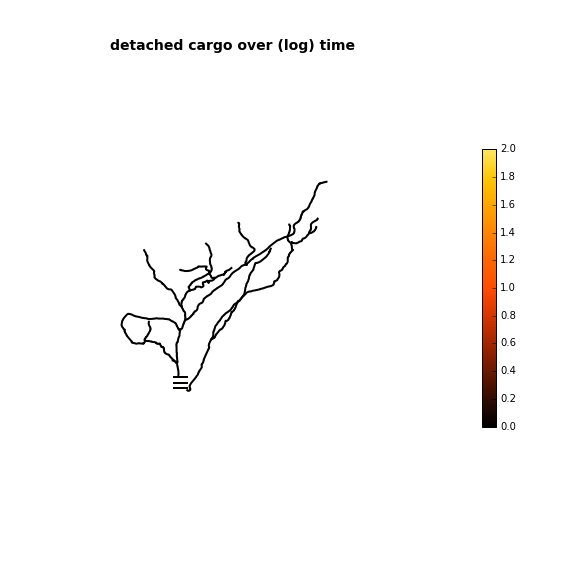
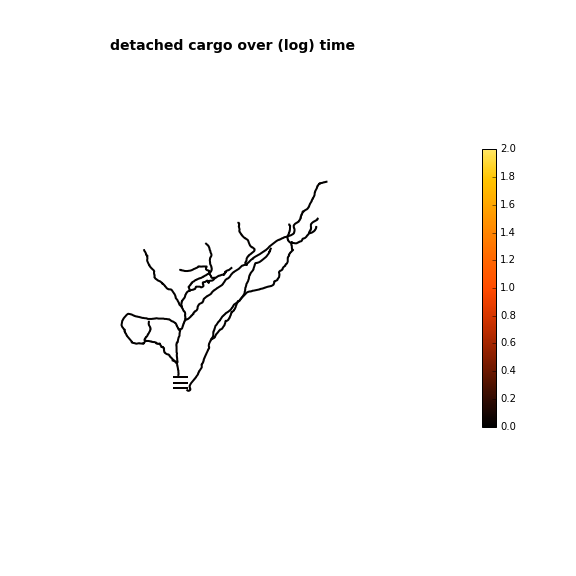
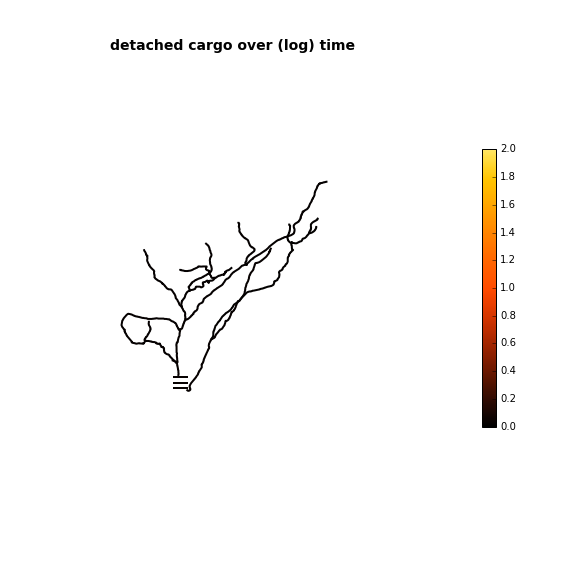
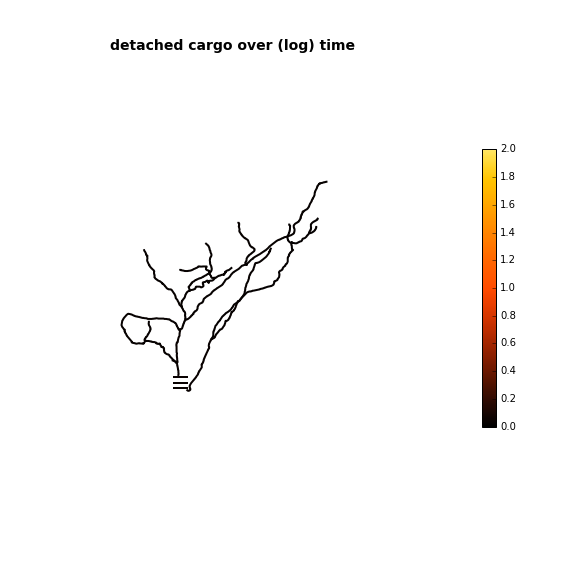
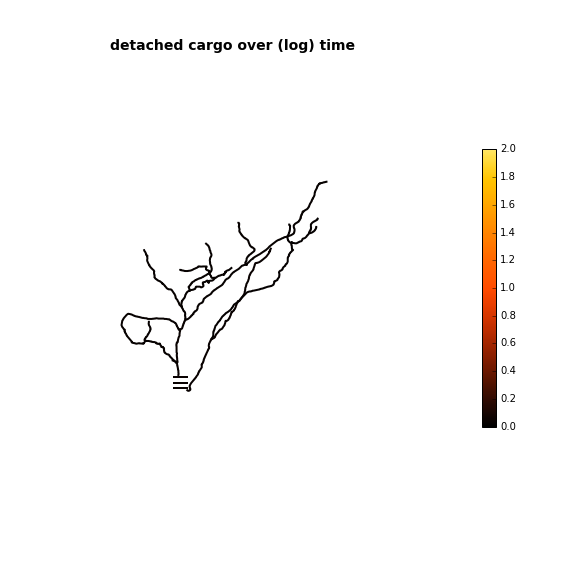
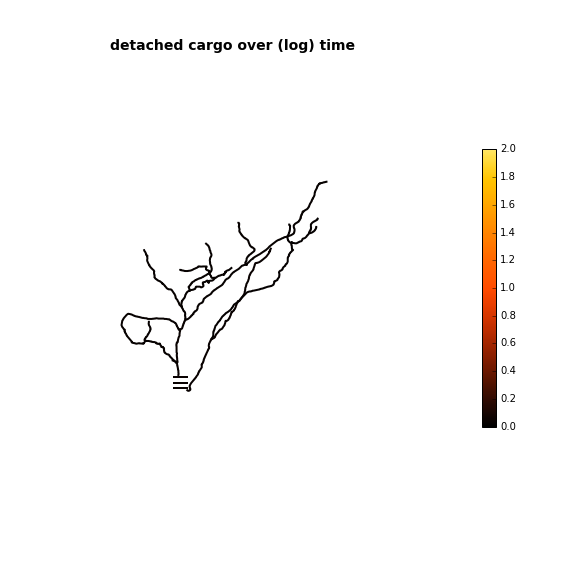
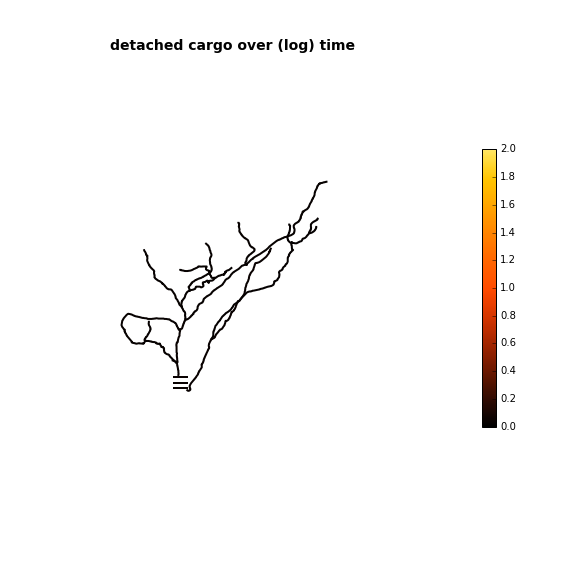
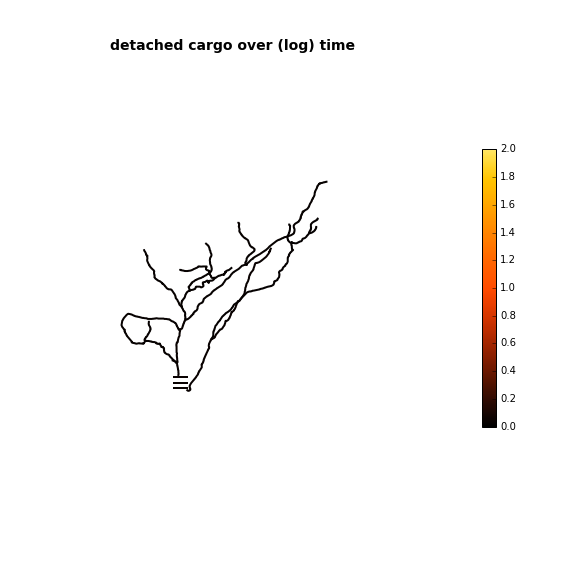
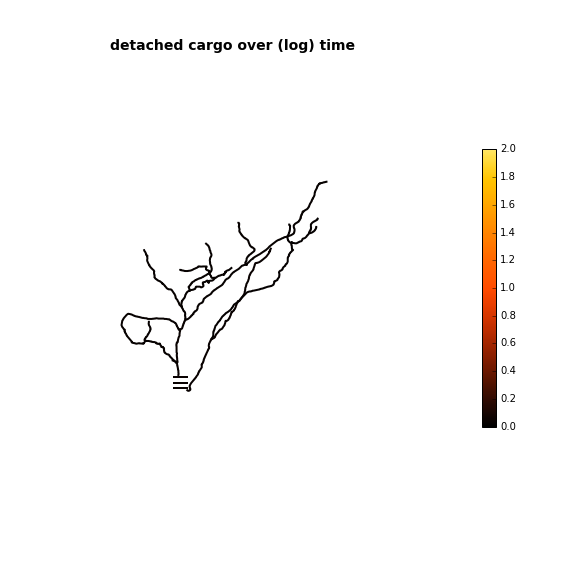
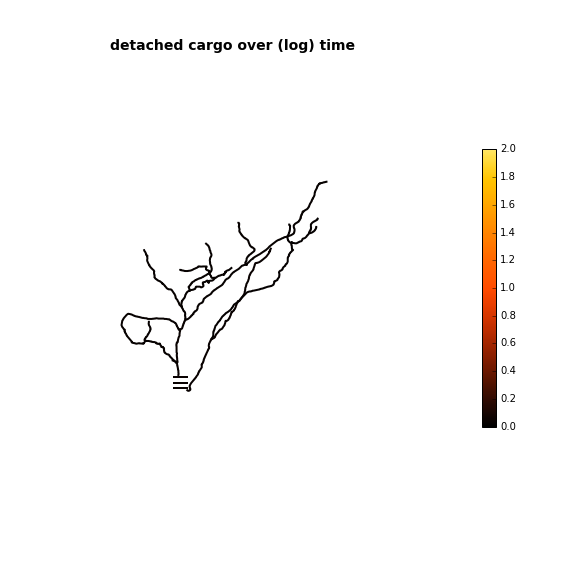
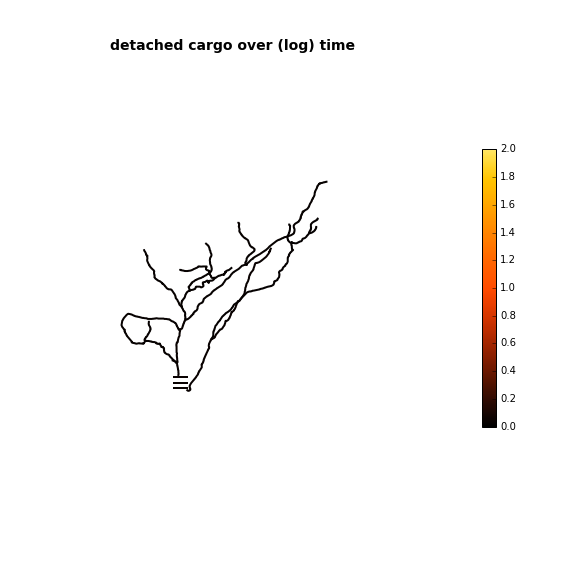
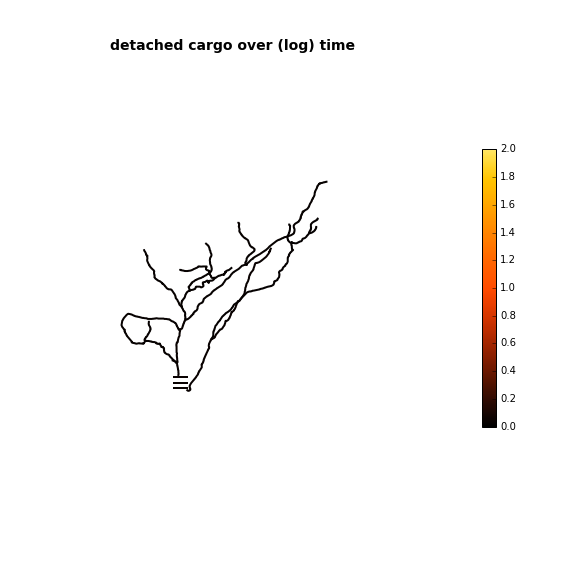
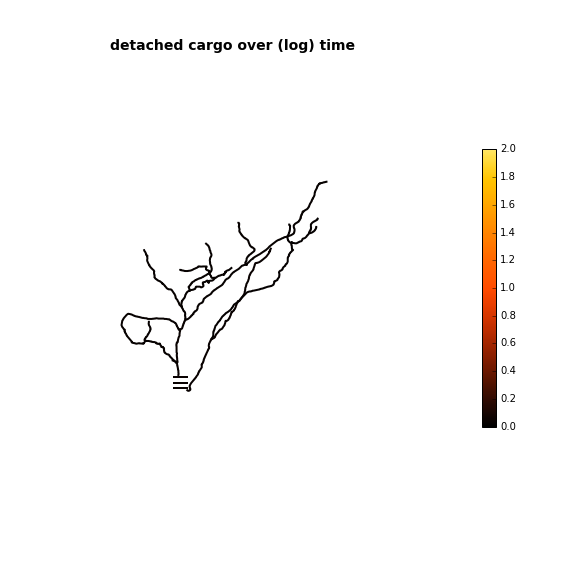
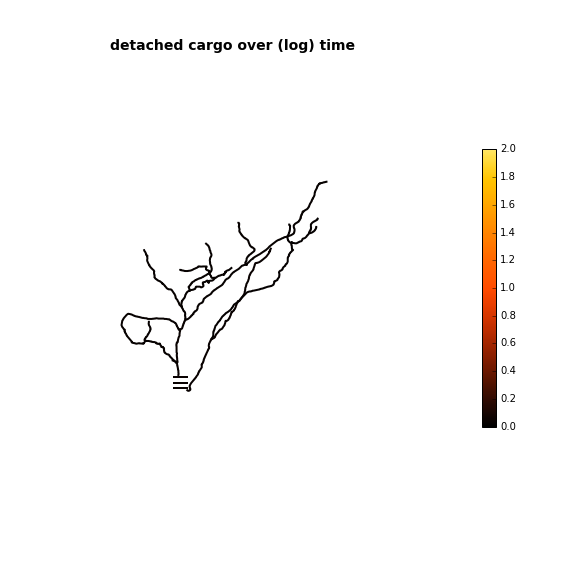
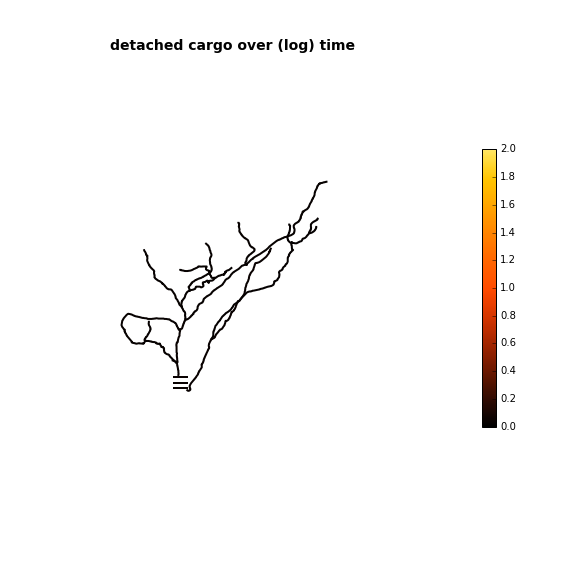

In [4]:
# Animation to show detached distribution
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
lines = morphology.shapeplot(h,ax,order='pre',lw=2)
ax.view_init(*view)
ax.set_axis_off()
plt.title('detached cargo over (log) time',fontweight='bold',fontsize=14)

# Hack to get a colorbar
# http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap=us_cmap, norm=plt.Normalize(clim[0],clim[1])) 
sm._A = []
plt.colorbar(sm, shrink=0.5)
plt.tight_layout()

#plt.show()
anim_func = morphology.shapeplot_animate(u[:,N:],lines,nframes,clim=clim,cmap=us_cmap)
anim = animation.FuncAnimation(fig, anim_func, frames=nframes, interval=400)
anim.save('./anim/no_reattach/'+cellname+'_us.mp4'); anim

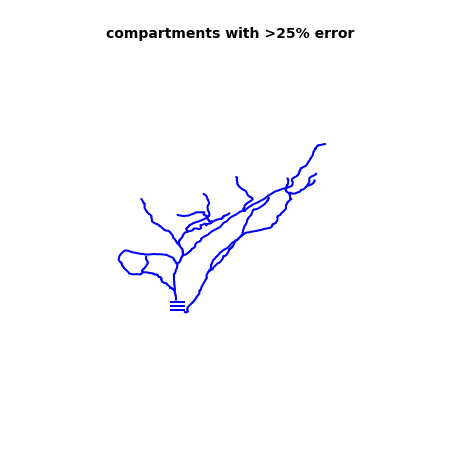

In [5]:
cols = [ 'r' if abs(e)>0.25 else 'b' for e in final_err ]
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
lines = morphology.shapeplot(h,ax,order='pre',lw=2,cvals=cols)
ax.view_init(*view)
ax.set_axis_off()
plt.title('compartments with >25% error',fontweight='bold',fontsize=14)
plt.savefig('./plots/no_reattach/granule_final_err.eps')

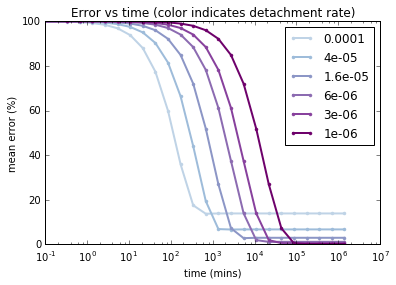

In [6]:
plt.figure()
palette = ['#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#6e016b']
detach_timescale = np.round(np.logspace(-4,-6,len(palette)),6)
err = []
for i in range(len(detach_timescale)):
    A,u,t,err_,ferr = sushi.run_uniform_sim(h, detach_timescale[i], 10.0)
    plt.plot(t/60,err_,'.-',color=palette[i],lw=2, label=detach_timescale[i])
    err.append(err_)

plt.xscale('log')
plt.ylabel('mean error (%)')
plt.xlabel('time (mins)')
plt.ylim([0,100])
plt.legend(loc='best')
plt.title('Error vs time (color indicates detachment rate)')
plt.show()

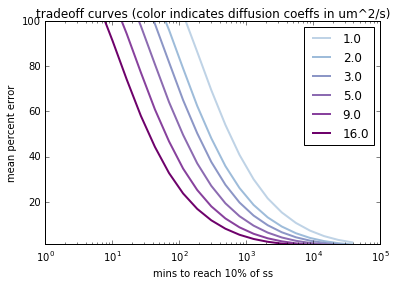

In [7]:
tradeoff = sushi.calc_tradeoff_curve(h,diff_coeff=10.0)
np.savetxt('./data/no_reattach/'+cellname+'_tradeoff.txt',tradeoff)

plt.figure()
dcs = np.round(np.logspace(0,1.2,6))
for i in range(len(palette)):
    tradeoff = sushi.calc_tradeoff_curve(h,diff_coeff=dcs[i])
    plt.plot(tradeoff[:,0],tradeoff[:,1],'-',lw=2,color=palette[i])
plt.xscale('log')
plt.xlim([1e0,1e5])
plt.ylim([1,100])
plt.xlabel('mins to reach 10% of ss')
plt.ylabel('mean percent error')
plt.title('tradeoff curves (color indicates diffusion coeffs in um^2/s)')
plt.legend(dcs)
plt.show()

# With Reattachment

In [8]:
A,u,t,excess,err = sushi.run_uniform_reattachment(h, 0.1, 10.0)
sushi.snapshots(h,u,t,'plots/with_reattach',cellname,view,u_cmap,us_cmap)
print 'excess cargo = %2.1f percent'%(excess[-1])

excess cargo = 9.1 percent



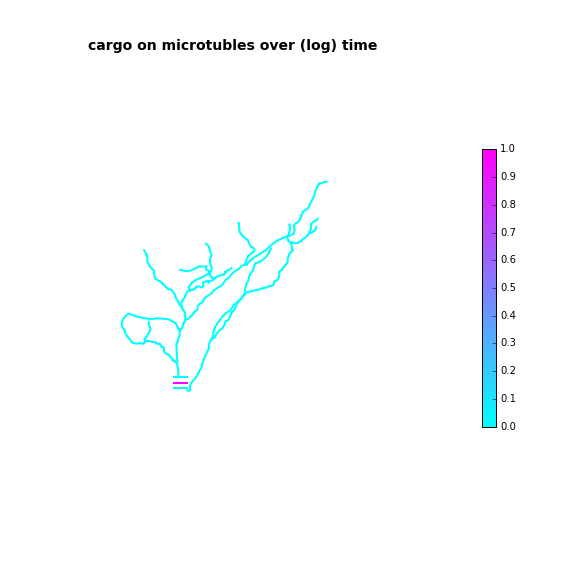
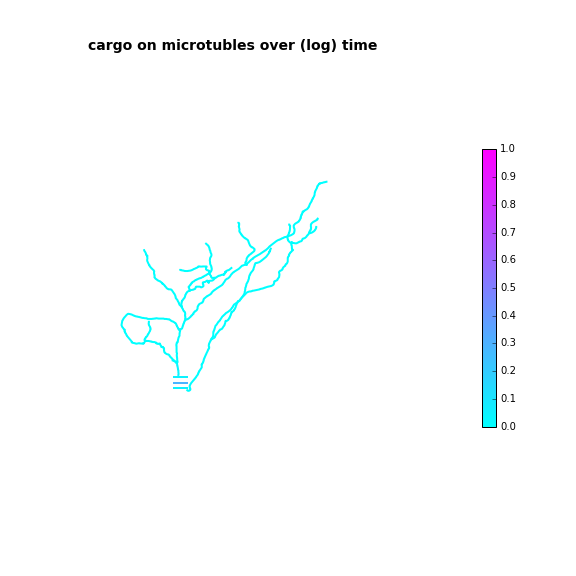
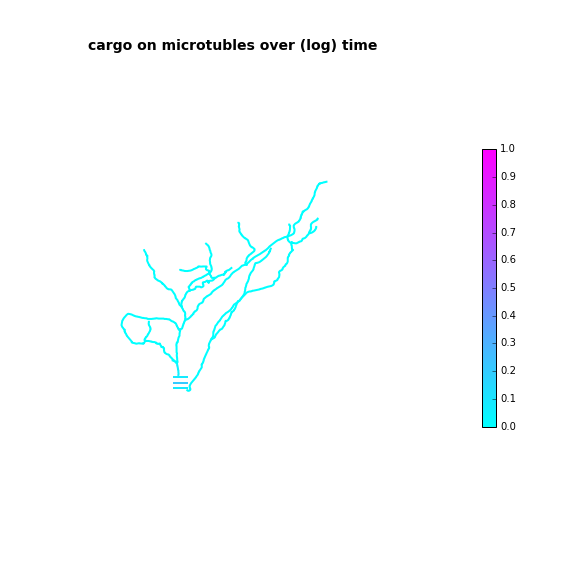
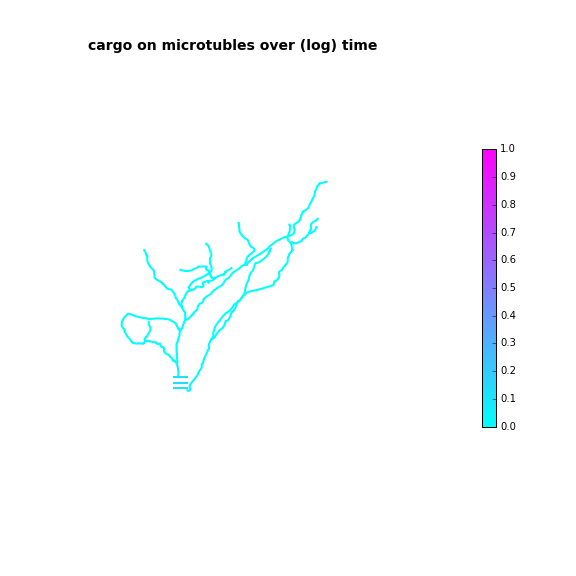
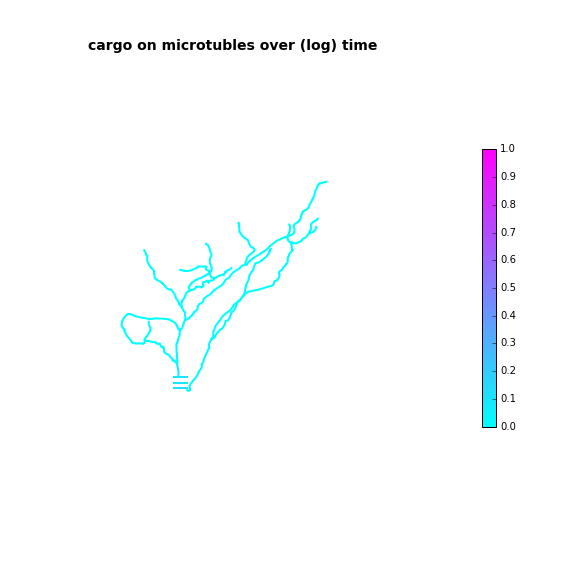
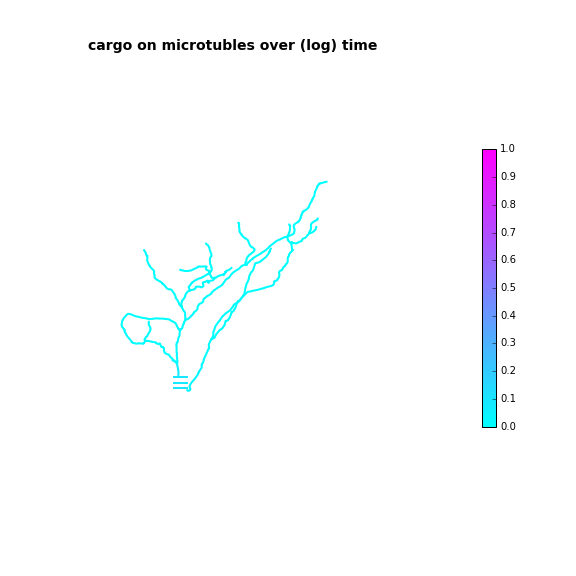
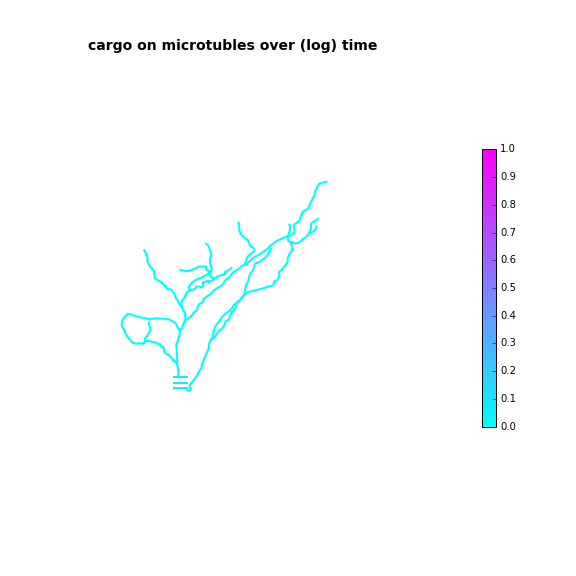
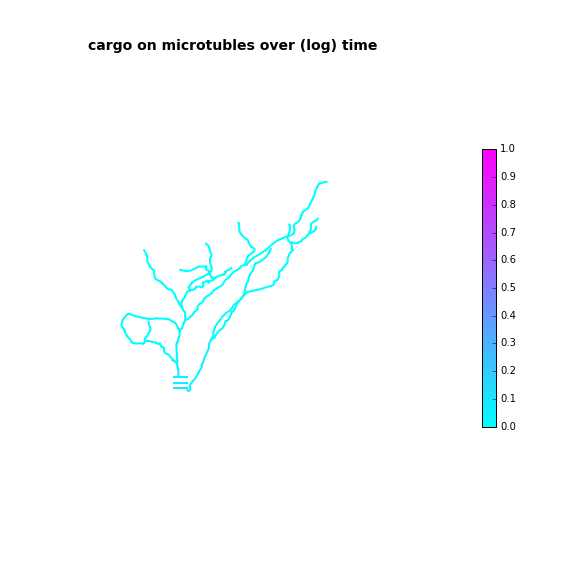
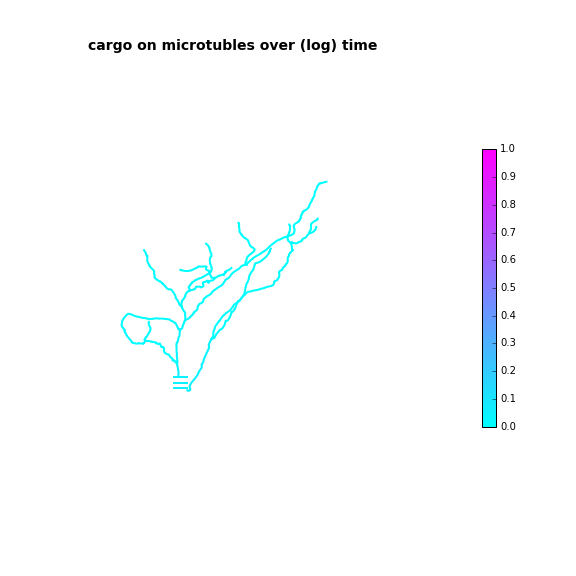
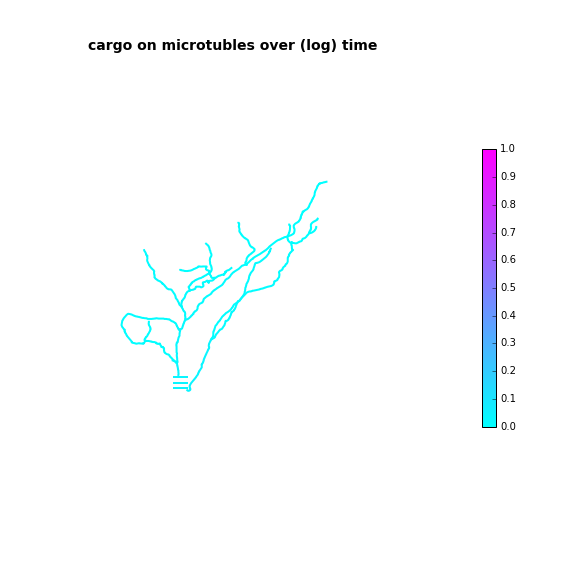
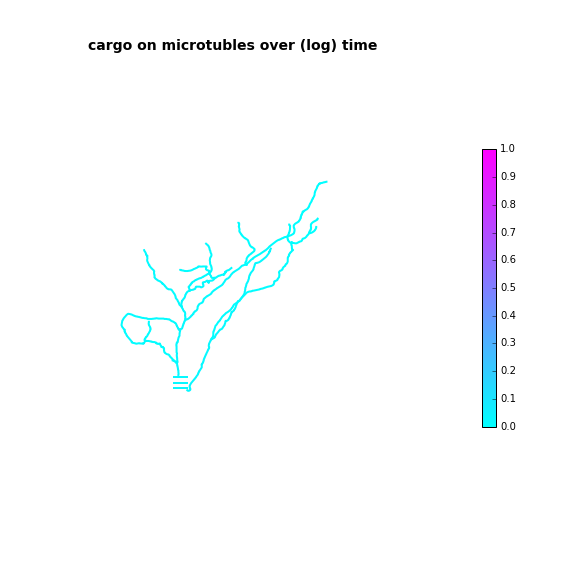
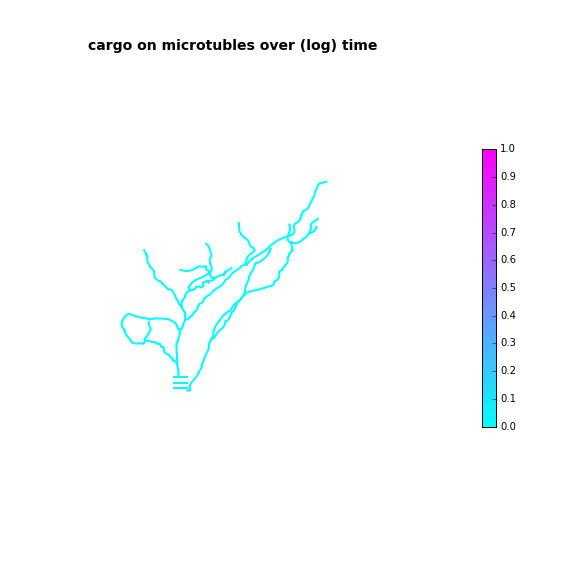
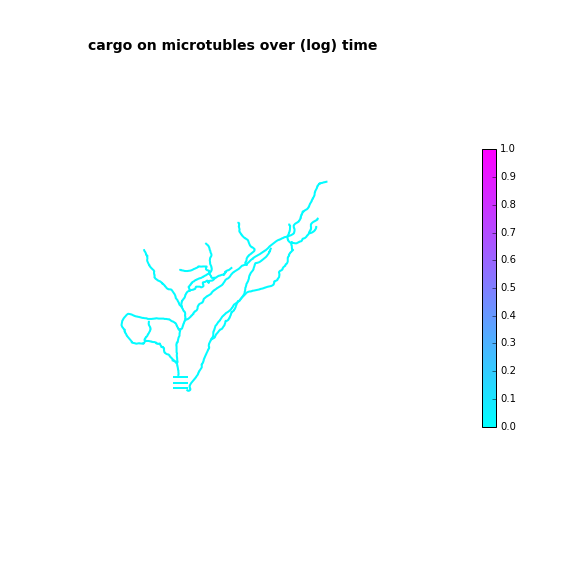
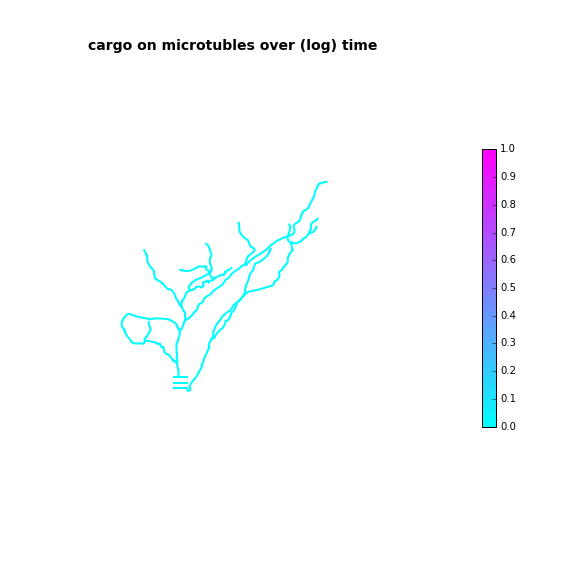
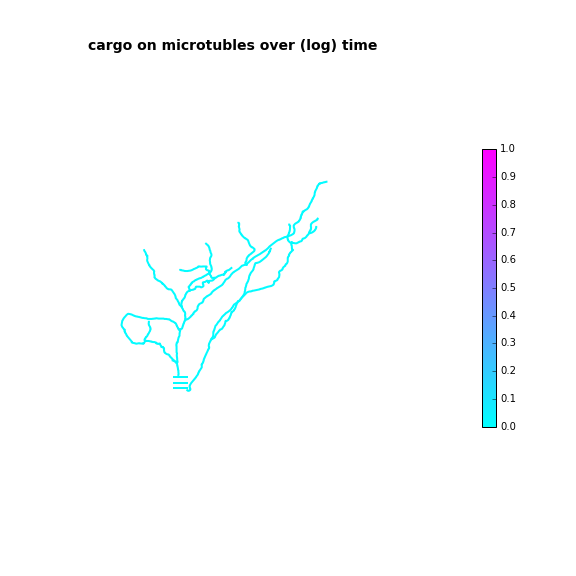
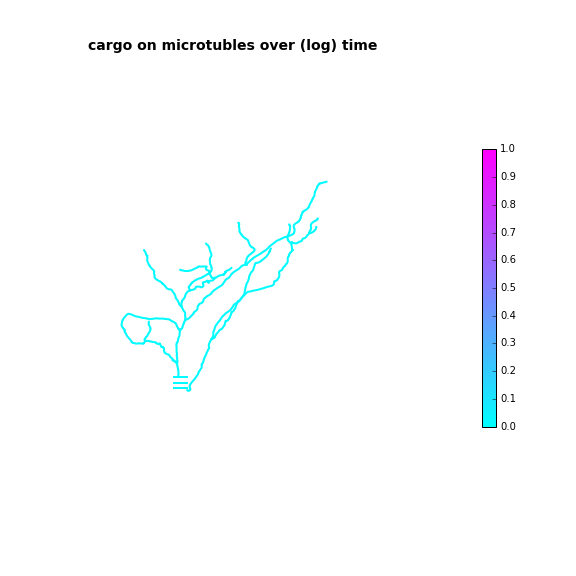
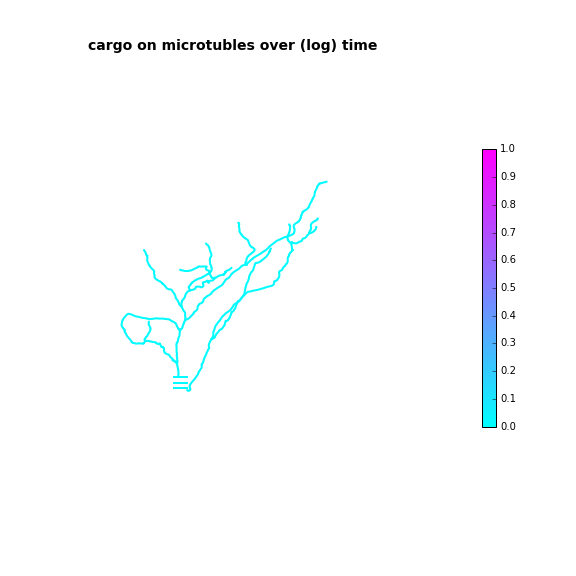
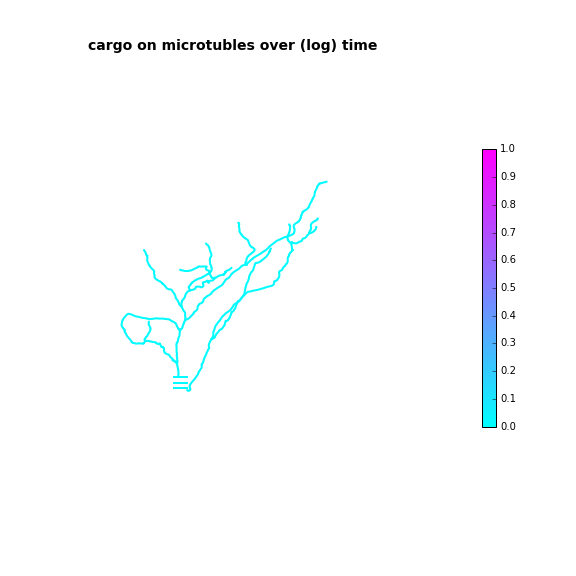
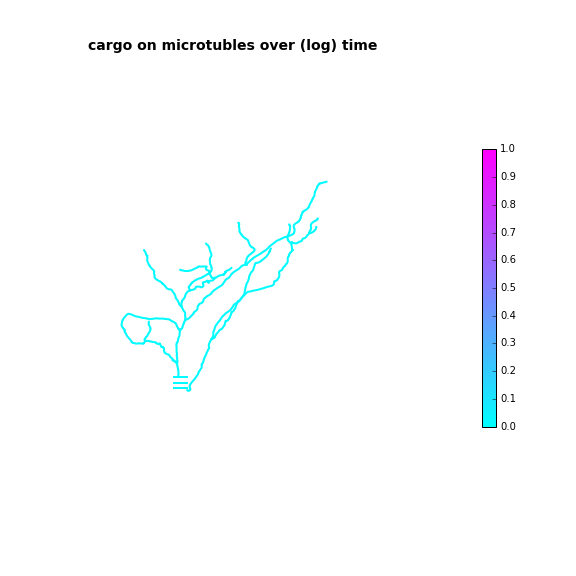
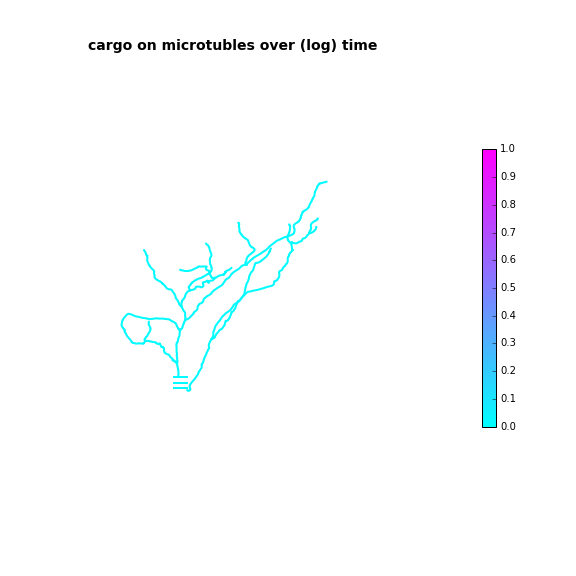
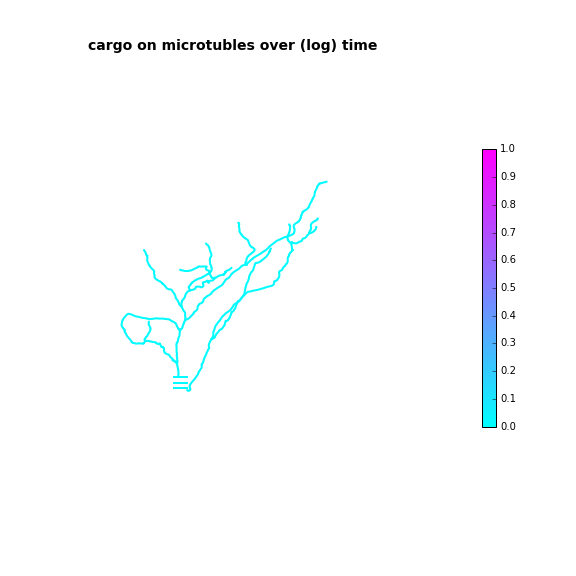
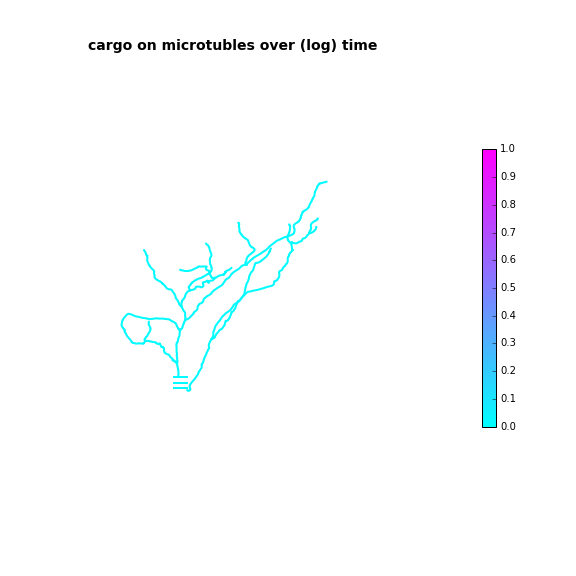
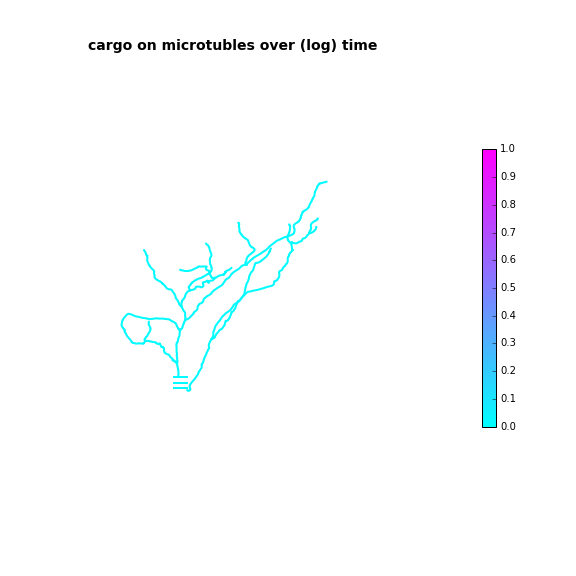
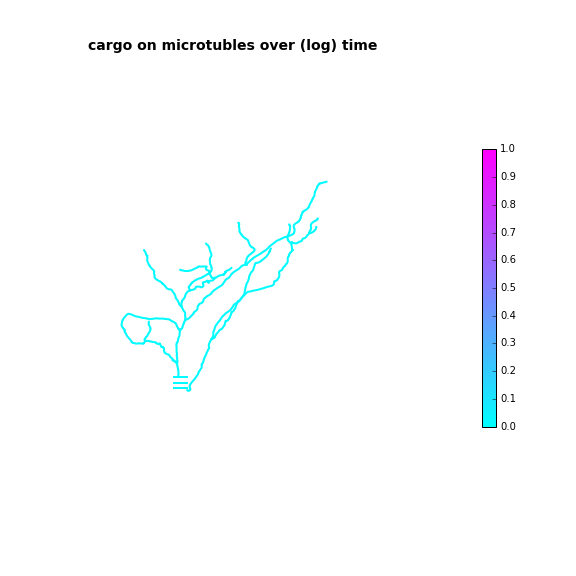

In [9]:
# Animation to show distribution on the microtubules
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
lines = morphology.shapeplot(h,ax,order='pre',lw=2)
ax.view_init(*view)
ax.set_axis_off()
plt.title('cargo on microtubles over (log) time',fontweight='bold',fontsize=14)

# Hack to get a colorbar
# http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap=u_cmap, norm=plt.Normalize([0,0.2])) 
sm._A = []
plt.colorbar(sm, shrink=0.5)
plt.tight_layout()

#plt.show()
anim_func = morphology.shapeplot_animate(u[:,:N],lines,nframes,clim=[0,0.2],cmap=u_cmap)
anim = animation.FuncAnimation(fig, anim_func, frames=nframes, interval=400)
anim.save('./anim/with_reattach/'+cellname+'_u.mp4'); anim


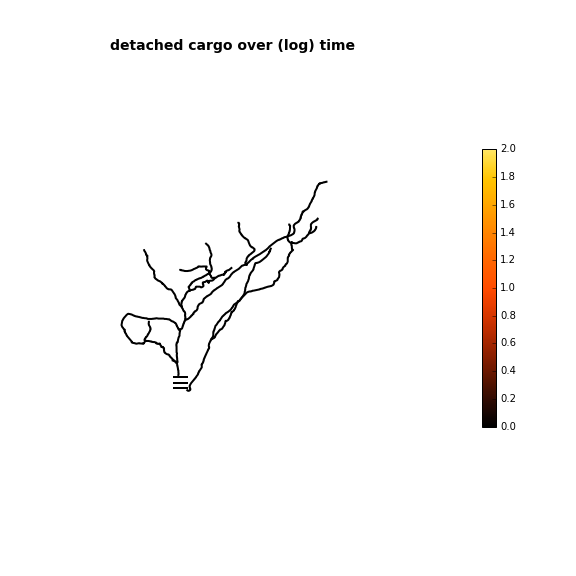
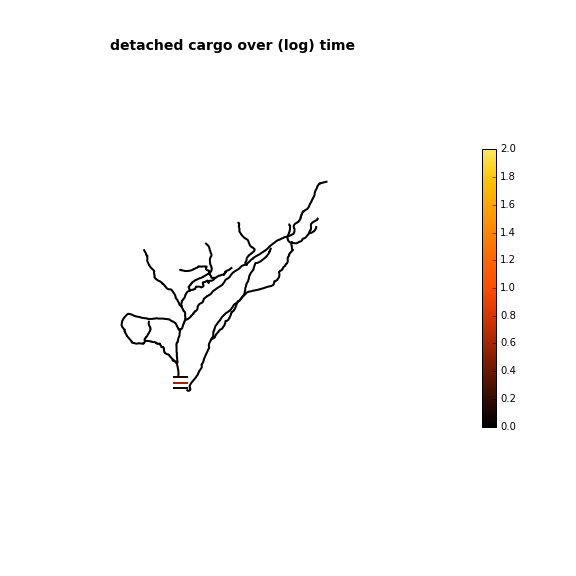
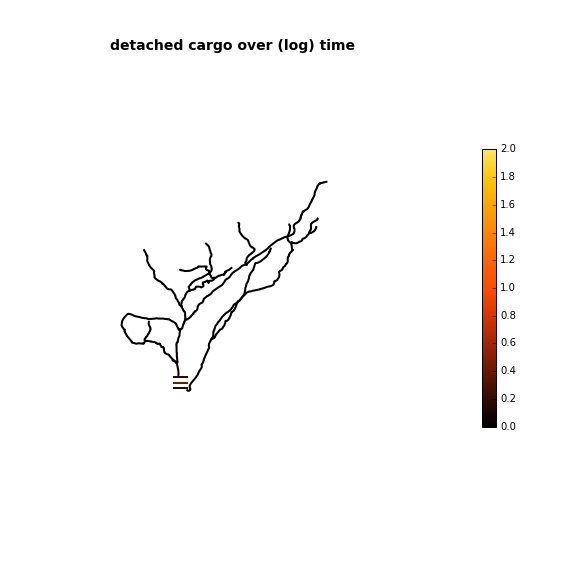
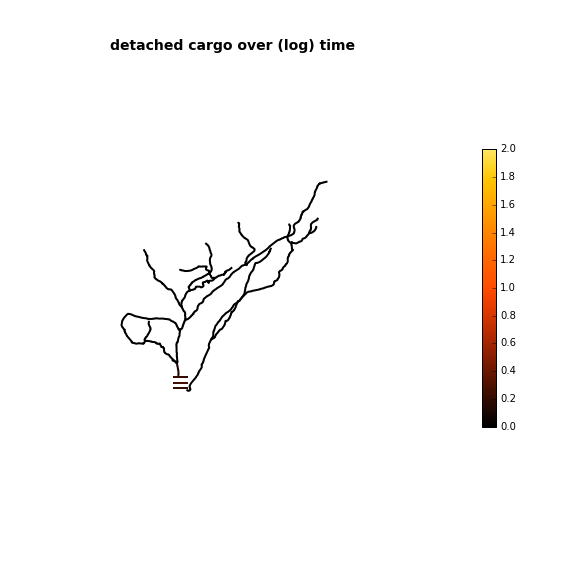
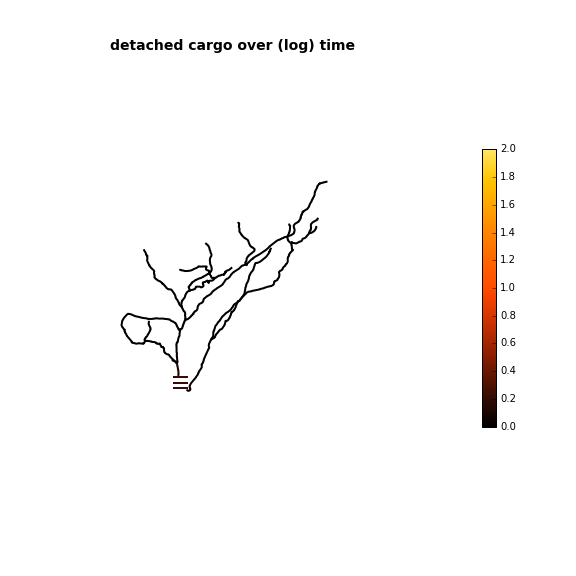
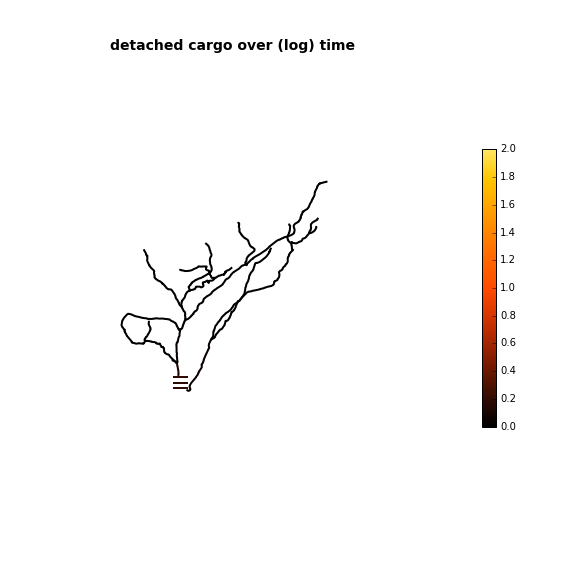
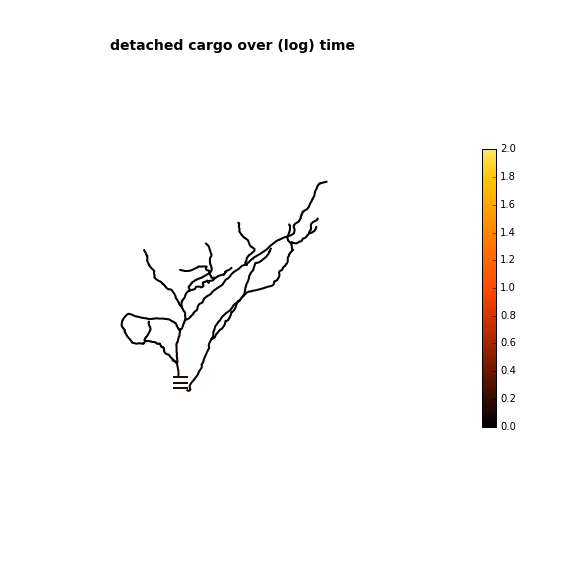
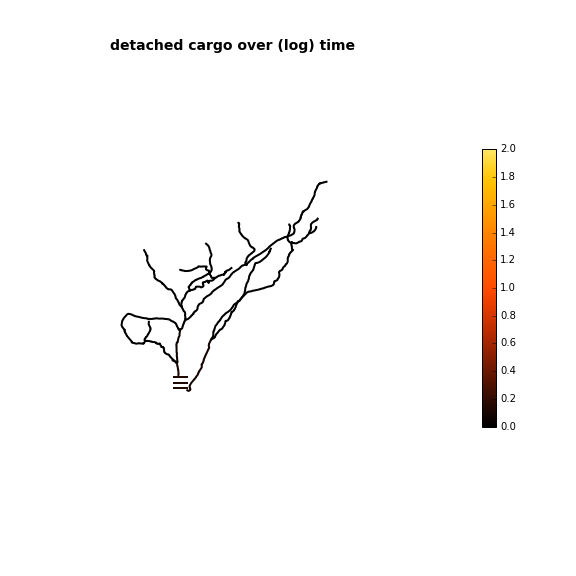
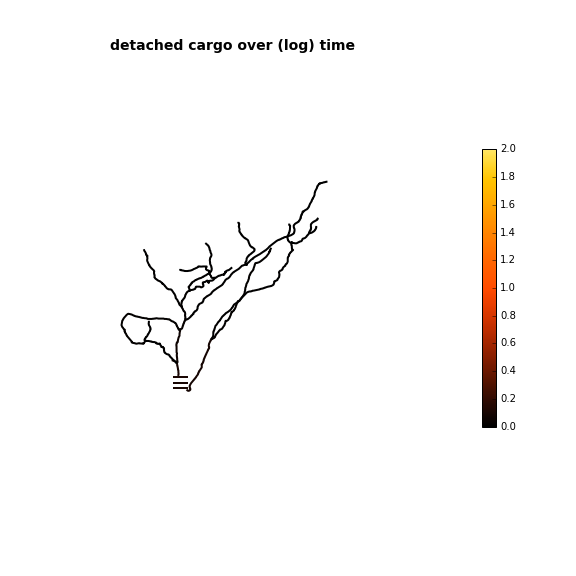
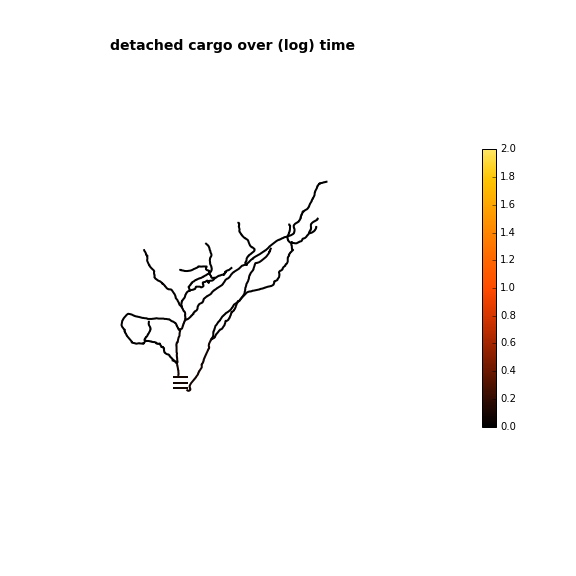
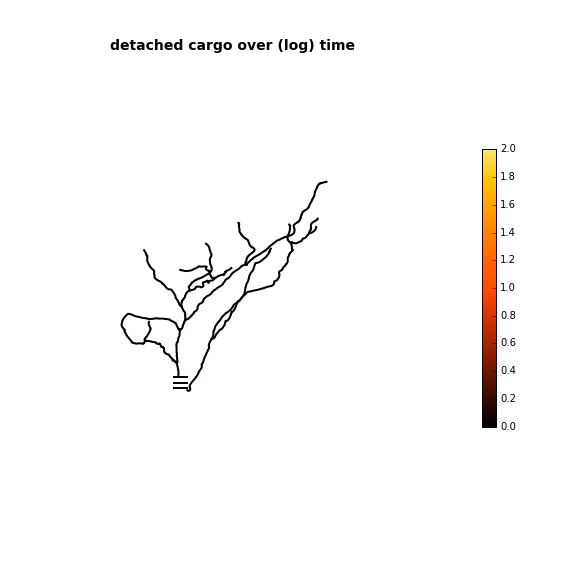
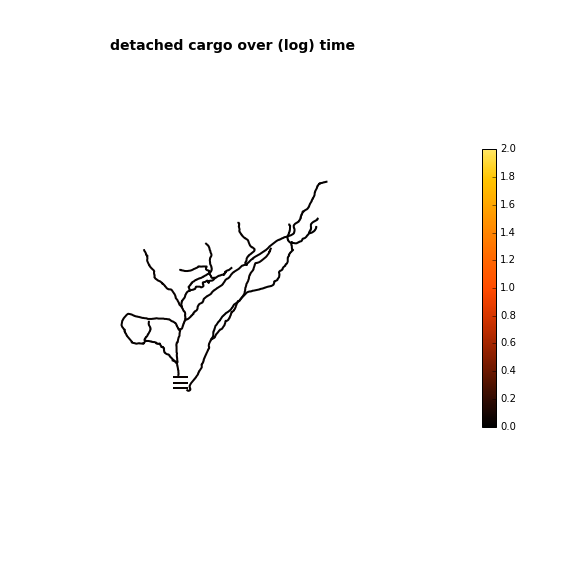
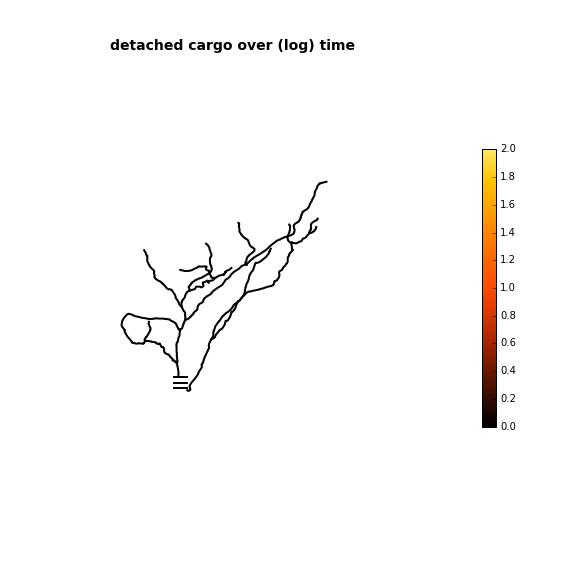
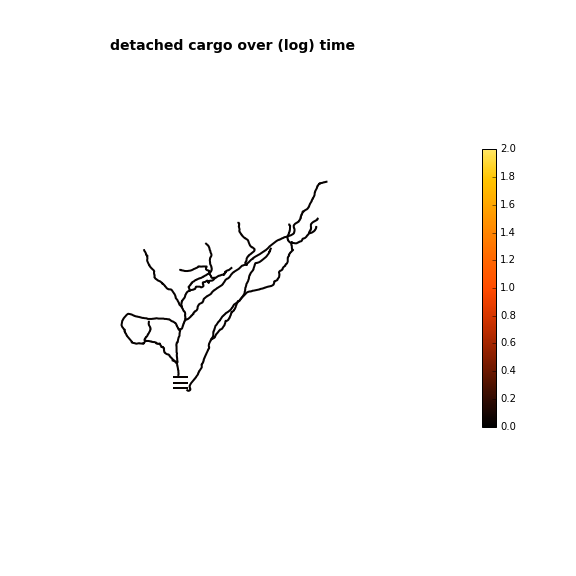
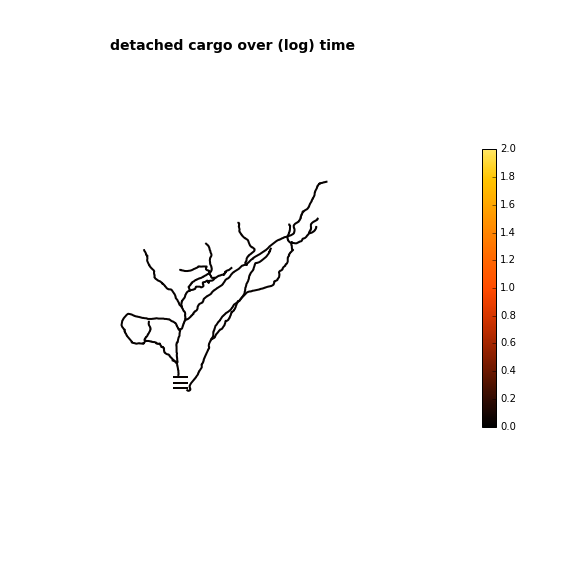
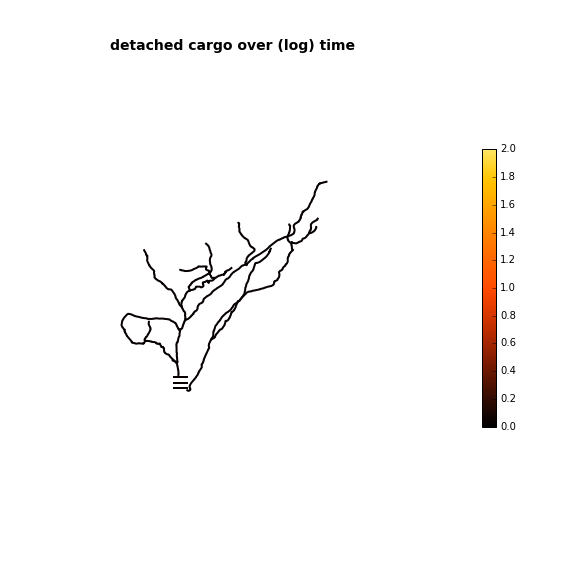
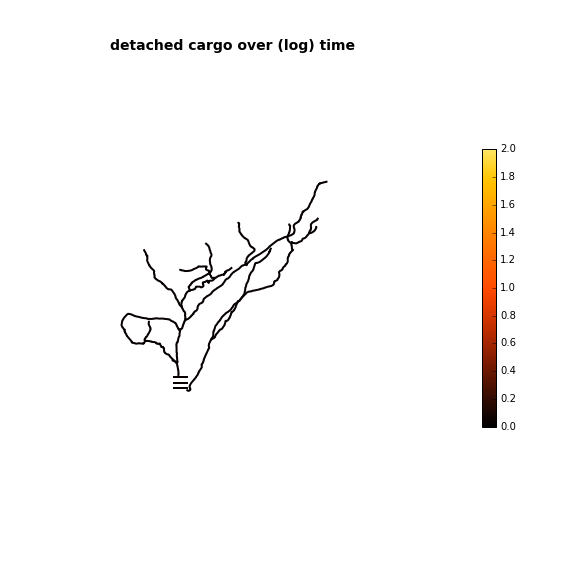
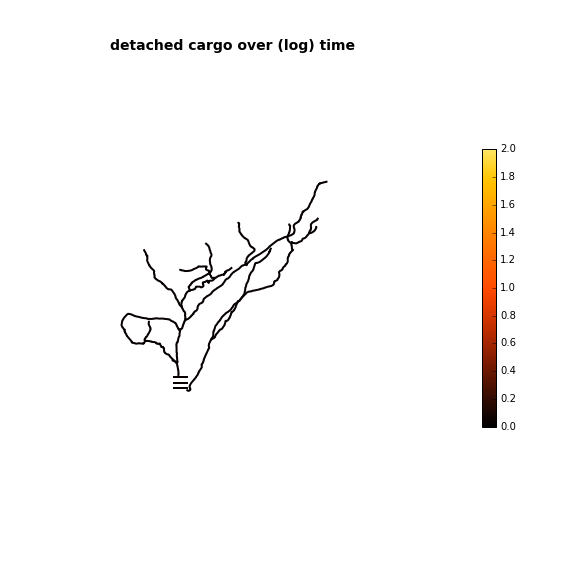
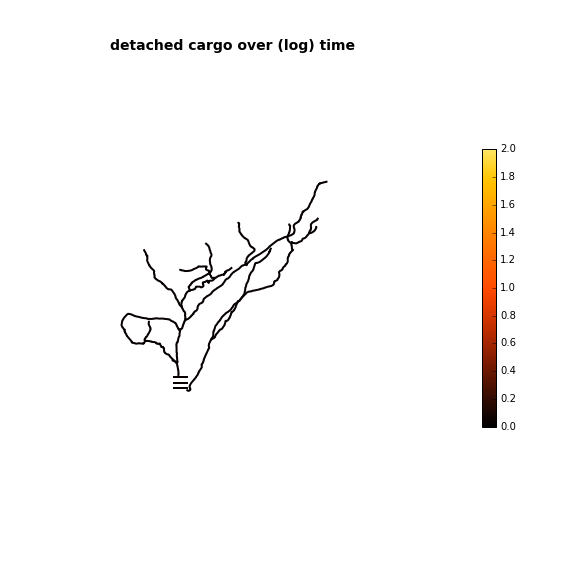
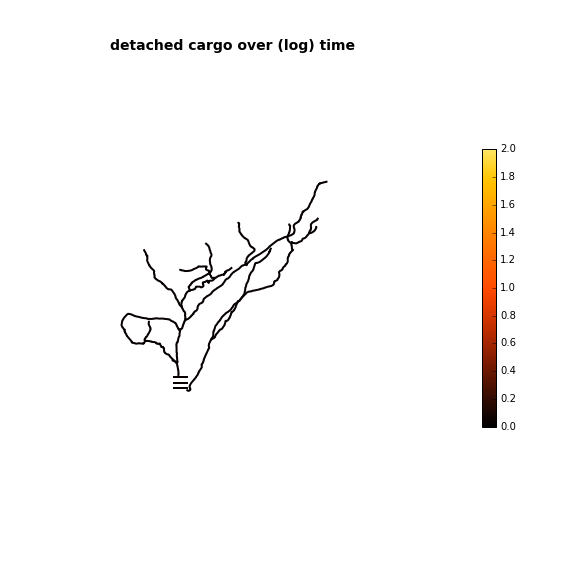
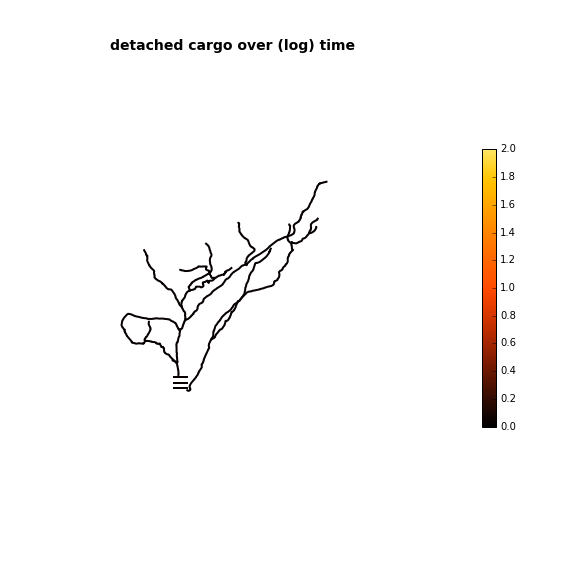
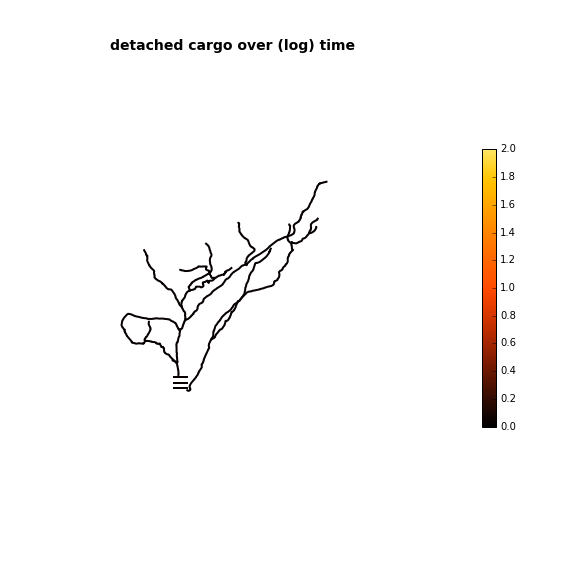
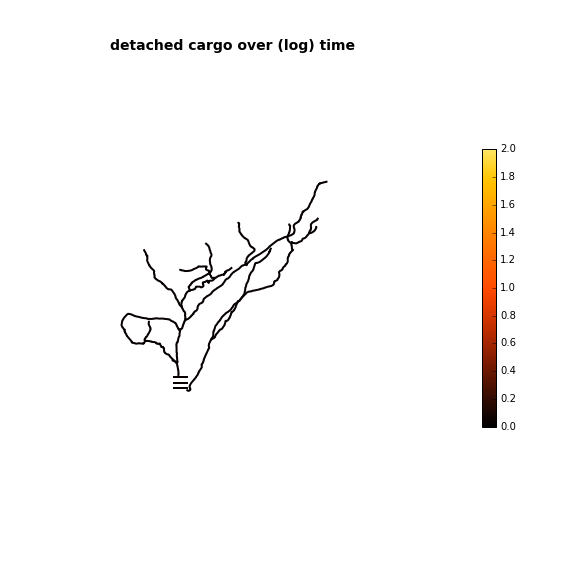
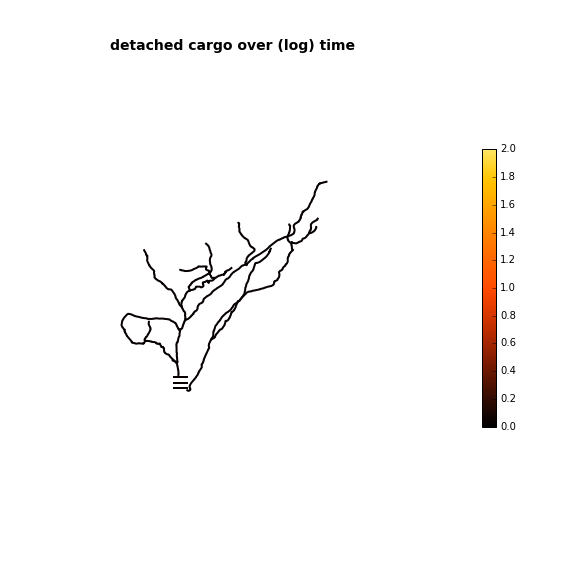

In [10]:
# Animation to show detached distribution
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
lines = morphology.shapeplot(h,ax,order='pre',lw=2)
ax.view_init(*view)
ax.set_axis_off()
plt.title('detached cargo over (log) time',fontweight='bold',fontsize=14)

# Hack to get a colorbar
# http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap=us_cmap, norm=plt.Normalize(clim[0],clim[1])) 
sm._A = []
plt.colorbar(sm, shrink=0.5)
plt.tight_layout()

#plt.show()
anim_func = morphology.shapeplot_animate(u[:,N:],lines,nframes,clim=clim,cmap=us_cmap)
anim = animation.FuncAnimation(fig, anim_func, frames=nframes, interval=400)
anim.save('./anim/with_reattach/'+cellname+'_us.mp4'); anim

excess: 0.990098 	 reattachment: 0.01
excess: 0.396521 	 reattachment: 0.003981
excess: 0.158249 	 reattachment: 0.001585
excess: 0.0630602 	 reattachment: 0.000631
excess: 0.0250937 	 reattachment: 0.000251
excess: 0.009999 	 reattachment: 0.0001


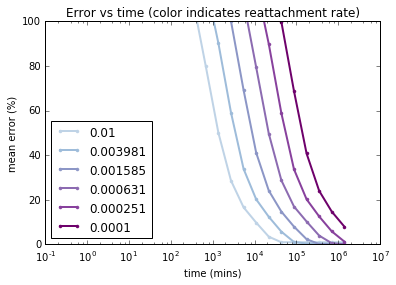

In [11]:
plt.figure()
detach_timescale = np.round(np.logspace(-2,-4,len(palette)),6)
err = []
for i in range(len(detach_timescale)):
    A,u,t,exc_,err_ = sushi.run_uniform_reattachment(h, detach_timescale[i], 10.0)
    print 'excess: %g \t reattachment: %g'%(exc_[-1], detach_timescale[i])
    plt.plot(t/60,err_,'.-',color=palette[i],lw=2, label=detach_timescale[i])
    err.append(err_)

plt.xscale('log')
plt.ylabel('mean error (%)')
plt.xlabel('time (mins)')
plt.ylim([0,100])
plt.legend(loc='best')
plt.title('Error vs time (color indicates reattachment rate)')
plt.show()

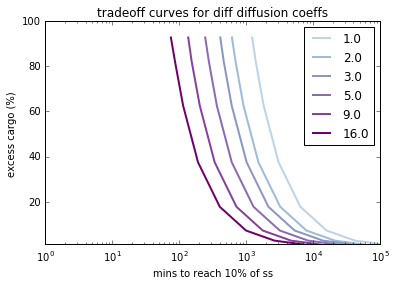

In [12]:
tradeoff = sushi.calc_tradeoff_reattachment(h,diff_coeff=10.0)
np.savetxt('./data/with_reattach/'+cellname+'_tradeoff.txt',tradeoff)

plt.figure()
dcs = np.round(np.logspace(0,1.2,6))
for i in range(len(palette)):
    tradeoff = sushi.calc_tradeoff_reattachment(h,diff_coeff=dcs[i])
    x,y = tradeoff[:,0],tradeoff[:,1]
    plt.plot(x[y<98],y[y<98],'-',lw=2,color=palette[i])
plt.xscale('log')
plt.xlim([1e0,1e5])
plt.ylim([1,100])
plt.xlabel('mins to reach 10% of ss')
plt.ylabel('excess cargo (%)')
plt.title('tradeoff curves for diff diffusion coeffs')
plt.legend(dcs)
plt.show()